<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/LLM_Court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import time
import re
import openai
import json
from sklearn.model_selection import train_test_split
import ast
from google.colab import userdata

In [ ]:
def fix_hebrew_labels(ax):
    """ Reverse Hebrew labels in Matplotlib plots. """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        text = label.get_text()
        if any("\u0590" <= char <= "\u05FF" for char in text):  # Detect Hebrew characters
            label.set_text(text[::-1])
    ax.figure.canvas.draw()


In [ ]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

folder_id = "בית המשפט - קבצים שנבדקו"
directory_path = f"/content/drive/My Drive/{folder_id}"
classifiers_path = "/content/drive/MyDrive/בית המשפט - מסווגים/"

if not os.path.exists(directory_path):
    print(f"Directory {directory_path} does not exist. Please check the folder path.")
else:
    dataframes = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_excel(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to read {file_name}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("All Excel files have been concatenated successfully!")

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


All Excel files have been concatenated successfully!


In [ ]:
full_ra_rap = pd.read_excel("/content/drive/My Drive/full_ra_rap.xlsx")

In [ ]:
check_gender_bias = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
check_gender_bias = pd.merge(full_ra_rap, check_gender_bias, on='מספר הליך', how='left')
check_gender_bias.drop_duplicates(subset = 'מספר הליך',inplace = True)
check_gender_bias.dropna(subset = ["בקשה לרשות ערעור התקבלה?"],inplace=True)

In [ ]:
for col in check_gender_bias.columns:
    if(col.find("מגדר")!=-1 or col.find("ערעור")!=-1 or col.find("מספר ")!=-1):
      print(col)

מספר תיק
מספר החלטות בתיק
מספר הליך
מספר גורמים שיפוטיים במותב
מגדר
מספר מילים בגוף המסמך
מספר עמודים
מספר צדדים בתיק
מספר תיקי דלמטה בתיק
מספר דיונים בתיק
מספר אירועים בתיק
מספר אישורי מסירה בתיק
מספר בקשות בתיק
מספר צד
מספר הבקשה
מספר תיק דלמטה מלא
מספר תיק דלמטה
מספר תיק מלא
מספר השופטים
בקשה לרשות ערעור התקבלה?
הערעור התקבל?
הערות תוצאת ערעור
prediction_adjusted_threshold
בקשת רשות ערעור התקבלה?
prediction_second_model_adjusted
ערעור התקבל?


In [ ]:
check_gender_bias = check_gender_bias[["מספר הליך","מספר השופטים","בקשה לרשות ערעור התקבלה?","מגדר"]]

In [ ]:
check_gender_bias[["בקשה לרשות ערעור התקבלה?","מגדר"]]

בקשה לרשות ערעור התקבלה?                     מגדר
495                       נדחה                  ['זכר']
503                       נדחה                  ['זכר']
537                       נדחה                  ['זכר']
539                        אחר                  ['זכר']
550                       נדחה                  ['זכר']
...                        ...                      ...
20482                     נדחה                  ['זכר']
20499                    התקבל  ['זכר', 'נקבה', 'נקבה']
20503                    התקבל   ['זכר', 'נקבה', 'זכר']
20540                      אחר                 ['נקבה']
20560                    התקבל    ['זכר', 'זכר', 'זכר']

[702 rows x 2 columns]

<ipython-input-935-533c6d08d180>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה


<Figure size 800x500 with 0 Axes>

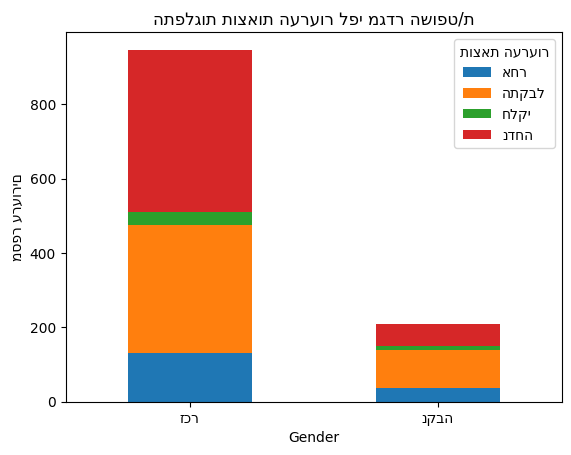

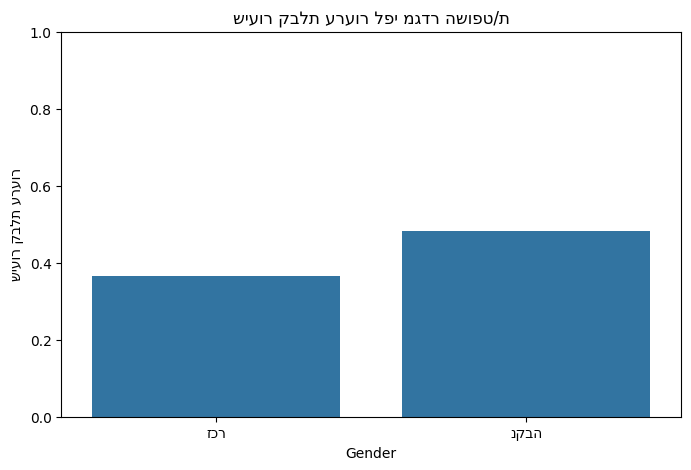

Appeal Outcome  אחר  התקבל  חלקי  נדחה  Total  Acceptance Rate
Gender                                                        
זכר             130    346    34   437    947         0.365364
נקבה             38    101    11    59    209         0.483254


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval


# המרת המחרוזת ברשימת מגדרים למבנה רשימה
check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה

# פונקציה להשטחת הנתונים – כל שופט יקבל שורה משלו
def expand_genders(df):
    expanded_data = []
    for _, row in df.iterrows():
        for gender in row["מגדר"]:
            expanded_data.append({"Gender": gender, "Appeal Outcome": row["בקשה לרשות ערעור התקבלה?"]})
    return pd.DataFrame(expanded_data)

# הרחבת הטבלה
df_expanded = expand_genders(check_gender_bias)

# ספירת תוצאות הערעור לפי מגדר
outcome_counts = df_expanded.groupby(["Gender", "Appeal Outcome"]).size().unstack().fillna(0)

# יצירת גרף התפלגות תוצאות לפי מגדר
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("מספר ערעורים")
plt.title("התפלגות תוצאות הערעור לפי מגדר השופט/ת")
plt.xticks(rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב יחס קבלת ערעור לכל מגדר
outcome_counts["Total"] = outcome_counts.sum(axis=1)
outcome_counts["Acceptance Rate"] = outcome_counts.get("התקבל", 0) / outcome_counts["Total"]

# יצירת גרף של אחוזי קבלת ערעור לפי מגדר
plt.figure(figsize=(8, 5))
sns.barplot(x=outcome_counts.index, y=outcome_counts["Acceptance Rate"])
plt.ylabel("שיעור קבלת ערעור")
plt.title("שיעור קבלת ערעור לפי מגדר השופט/ת")
plt.ylim(0, 1)
plt.show()

# הצגת הטבלה עם התוצאות
print(outcome_counts)


# Bias - number of Judges

<Figure size 800x500 with 0 Axes>

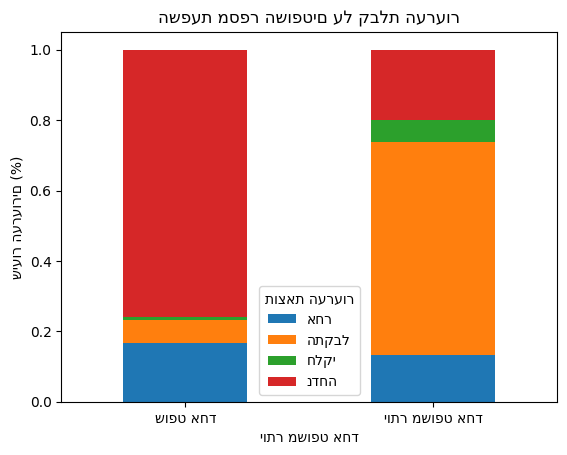

שיעור קבלת הערעור לפי מספר שופטים:
יותר משופט אחד
False    0.065126
True     0.606195
Name: התקבל, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# טעינת הנתונים
df = check_gender_bias.copy()

# חישוב מספר השופטים בכל תיק
df["מספר שופטים"] = df["מגדר"].apply(len)

# חלוקת המקרים לשתי קבוצות: שופט יחיד או יותר מאחד
df["יותר משופט אחד"] = df["מספר שופטים"] > 1

# ספירת המקרים לפי מספר השופטים והאם הערעור התקבל
outcome_counts = df.groupby("יותר משופט אחד")["בקשה לרשות ערעור התקבלה?"].value_counts(normalize=True).unstack()

# יצירת גרף
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("שיעור הערעורים (%)")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.xticks([0, 1], ["שופט אחד", "יותר משופט אחד"], rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב אחוז קבלת ערעור לפי מספר השופטים
acceptance_rate = outcome_counts.get("התקבל", 0)

# הדפסת סטטיסטיקה
print("שיעור קבלת הערעור לפי מספר שופטים:")
print(acceptance_rate)


<ipython-input-937-9995a47b4688>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")


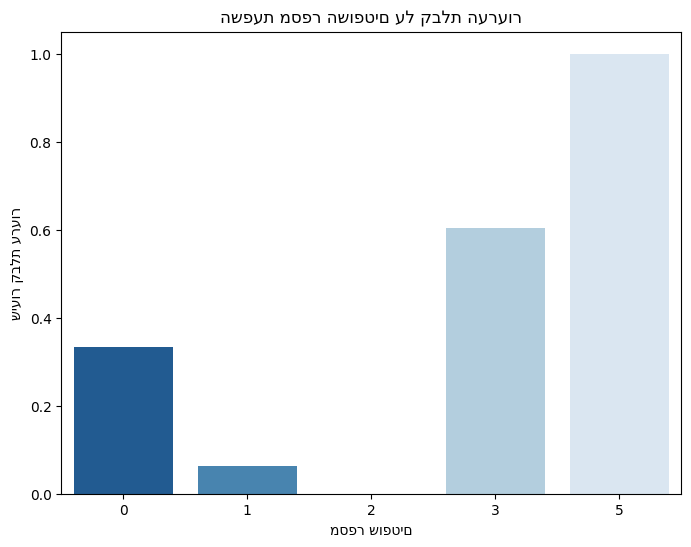

ערעור התקבל      0      1
מספר שופטים              
0              2.0    1.0
1            443.0   30.0
2              1.0    NaN
3             88.0  134.0
5              NaN    3.0
Chi-Square Test: p-value = 0.0000
מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.
טבלת שכיחות לפי נוכחות שופטות:
 ערעור התקבל    0   1
מכיל נקבה           
False        433  87
True         101  81


<ipython-input-937-9995a47b4688>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")


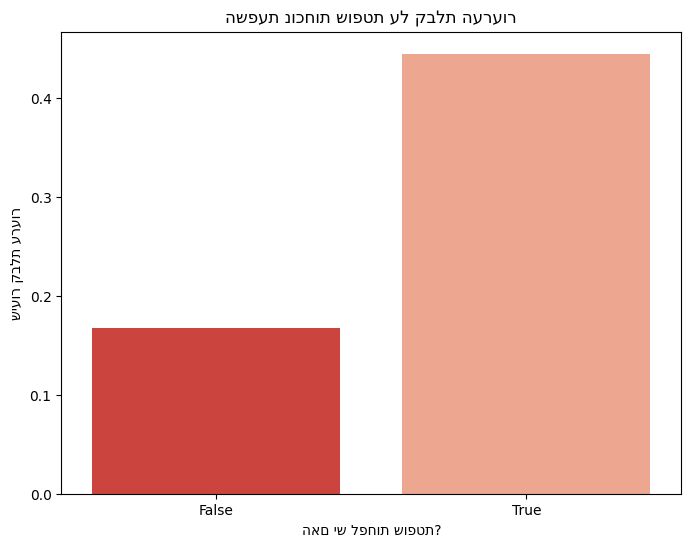

Chi-Square Test for Gender Bias: p-value = 0.0000
מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.


In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

df = check_gender_bias.copy()

# לוודא שהעמודה 'מגדר' היא רשימה ולא מחרוזת
df["מגדר"] = df["מגדר"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# הוספת עמודת מספר השופטים בכל מקרה
df["מספר שופטים"] = df["מגדר"].apply(len)

# יצירת עמודת אינדיקטור אם הערעור התקבל או לא
df["ערעור התקבל"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: 1 if x == "התקבל" else 0)

### בדיקת הקשר בין מספר השופטים להחלטה ###
grouped_by_judges = df.groupby("מספר שופטים")["ערעור התקבל"].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")
plt.xlabel("מספר שופטים")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.show()

# טבלת שכיחות
judge_count_table = df.groupby("מספר שופטים")["ערעור התקבל"].value_counts().unstack()
print(judge_count_table)

# בדיקה סטטיסטית - האם יש קשר מובהק בין מספר שופטים להחלטה
chi2, p, _, _ = chi2_contingency(judge_count_table.fillna(0))
print(f"Chi-Square Test: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")
else:
    print("מסקנה: אין קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")

### בדיקת ביאס מגדרי ###
# חישוב אחוז קבלת ערעור לפי מגדר
def get_gender_stats(gender_list, outcome):
    return any(g in gender_list for g in outcome)

df["מכיל זכר"] = df["מגדר"].apply(lambda x: "זכר" in x)
df["מכיל נקבה"] = df["מגדר"].apply(lambda x: "נקבה" in x)

# בדיקת הבדל בין מקרים עם לפחות שופטת לבין אלו ללא
gender_bias_table = df.groupby("מכיל נקבה")["ערעור התקבל"].value_counts().unstack()
print("טבלת שכיחות לפי נוכחות שופטות:\n", gender_bias_table)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")
plt.xlabel("האם יש לפחות שופטת?")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת נוכחות שופטת על קבלת הערעור")
plt.show()

# בדיקה סטטיסטית - האם יש הבדל מובהק
chi2, p, _, _ = chi2_contingency(gender_bias_table.fillna(0))
print(f"Chi-Square Test for Gender Bias: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")
else:
    print("מסקנה: אין עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")


In [ ]:
len(dataframes)

6

In [ ]:
df_1 = dataframes[0].copy()

df_1.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר'],
      dtype='object')

In [ ]:
df_1 = df_1[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',  'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ',
       'הערות קידוד חוזר']]

In [ ]:
df_2 = dataframes[1].copy()

In [ ]:
df_2 = df_2[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'הערות תוצאת ערעור', 'הערות ', 'הערות קידוד חוזר']]

In [ ]:
df = pd.concat([df_1, df_2], ignore_index=True)

In [ ]:
df_3 = dataframes[2].copy()

In [ ]:
df_3 = df_3[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ']]

In [ ]:
df = pd.concat([df, df_3], ignore_index=True)

In [ ]:
columns_to_check = [
    "הערות ",
    "הערות תוצאת ערעור",
    "הערות קידוד חוזר",
    "טקסט שמצביע על תוצאת בקשה שונה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)"
]


df = df[~df[columns_to_check].isna().all(axis=1)]

In [ ]:
df.shape

(348, 13)

In [ ]:
len(df["גוף המסמך"])

df["length"] = df["גוף המסמך"].apply(lambda x: len(str(x).split()))

average_length = df["length"].mean()
max_length = df["length"].max()
min_length = df["length"].min()

print(f"אורך ממוצע של פסקי דין: {average_length:.2f} מילים")
print(f"פסק הדין הארוך ביותר מכיל {max_length} מילים")
print(f"פסק הדין הקצר ביותר מכיל {min_length} מילים")


אורך ממוצע של פסקי דין: 722.41 מילים
פסק הדין הארוך ביותר מכיל 5920 מילים
פסק הדין הקצר ביותר מכיל 60 מילים


In [ ]:
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            text_list = ast.literal_eval(text)
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif isinstance(text, str):
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים

        text = re.sub(r"העותק כפוף לשינויי עריכה וניסוח.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"מרכז מידע, טל' \d{2,3}-\d{6,7}.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"אתר אינטרנט, .*?$", "", text, flags=re.MULTILINE)
    return text

print("שורות לא קריאות לפני המרה:")
print(df["גוף המסמך"].head())

df["גוף המסמך"] = df["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(df["גוף המסמך"].head())

file_path_full = 'checked_df_cleaned.csv' # FULL RAP DATA CLEANED
df.to_csv(file_path_full, index=False, encoding='utf-8')


שורות לא קריאות לפני המרה:
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
def extract_relevant_part(text):
    words = str(text).split()
    if len(words) > 1000:
        return " ".join(words[-800:-20])
    return text

df["גוף המסמך חתוך"] = df["גוף המסמך"].apply(extract_relevant_part)

df[["גוף המסמך", "גוף המסמך חתוך"]].head()


גוף המסמך  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע"פ 3622/15 לפני: כבוד השופט ח\' מלצר המבקש: יעקב סארה נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) מתאריך 12.05.2015 ב-ע"פ 28199-03-15 בשם המבקש: עו"ד בוריס קסונוביץ; עו"ד אלפסי ברנרד החלטה 1. לפני בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) ב-ע"פ 28199-03-15, בגדרו התקבל, באופן חלקי, ערעורו של המבקש על גזר דינו של בית המשפט השלום בנצרת (כב\' סגנית הנשיא ל\' יונג-גפר) ב-ת"פ 1687-01-14. לצד בקשת רשות הערעור, הוגשה גם בקשה לעיכוב ביצוע של עונש המאסר שהושת על המבקש. בהקשר זה הוריתי כי עונש המאסר בפועל שהושת על המבקש יעוכב עד למתן החלטה אחרת. אביא עתה את הנתונים הרלבנטיים להכרעה במכלול. רקע והליכים קודמים 2. בית משפט השלום הנכבד הרשיע את המבקש, על פי הודאתו, במסגרת הסדר טיעון – בעבירות אלימות שיוחסו לו בכתב אישום מתוקן שהוגש נגדו ונגד שני נאשמים נוספים (להלן: נאשם 1 ונ

In [ ]:
df = df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ', 'הערות קידוד חוזר',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור', 'length',]]

In [ ]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("\n", "")
df.columns = df.columns.str.replace("  ", " ")

In [ ]:
df.rename(columns={
    'הערות ':"הערות",
    'טקסט שמצביע על תוצאת בקשה שונה':"טקסט שמצביע על תוצאת בקשה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)": "טקסט שמצביע על התוצאה"
}, inplace=True)

df.columns


Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length'],
      dtype='object')

In [ ]:
columns_to_merge = [
    'טקסט שמצביע על תוצאת בקשה',
    'רע"פ בקשה אחרת או דלמטה מיוחד',  "הערות", 'הערות קידוד חוזר',
    "טקסט שמצביע על התוצאה",
    'הערות תוצאת ערעור'
]

def clean_merge_columns(row, columns):
    values = []
    for col in columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            text = f"{str(row[col]).strip()}"
            text.replace("?", "")
            text
            text = re.sub(r"הערה של \S+\s*", "", text)
            values.append(text)

    return "\n".join(values) if values else None

# יצירת עמודה מאוחדת עם כותרות לכל ערך
df["תוצאה מסכמת"] = df.apply(lambda row: clean_merge_columns(row, columns_to_merge), axis=1)


# הצגת מספר דוגמאות לבדיקה
df[["תוצאה מסכמת"]].head()


תוצאה מסכמת
5                      לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
31                                בקשה לעיכוב ביצוע עונש מאסר\nבקשה אחרת
67                               אשר על כן, הבקשה לרשות ערעור נדחית בזאת
73                                                   - זהו פסק דין משלים
114  חזרו בהם באי כוח המבקשים מהבקשות למתן רשות ערעור, והבקשות נדחות בזה

In [ ]:

for i in range(3):
    print(f"פסק דין {i+1} (תוצאה מסכמת):\n")
    print(df["תוצאה מסכמת"].iloc[i])
    print("="*80)


פסק דין 1 (תוצאה מסכמת):

לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
פסק דין 2 (תוצאה מסכמת):

בקשה לעיכוב ביצוע עונש מאסר
בקשה אחרת
פסק דין 3 (תוצאה מסכמת):

אשר על כן, הבקשה לרשות ערעור נדחית בזאת


In [ ]:
pd.set_option('display.max_colwidth', None)

df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [ ]:
df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [ ]:
df.to_excel("/content/dataframe_cleaned.xlsx", index=False)

# split - train, validation, test

In [ ]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

def convert_to_jsonl(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in data.iterrows():
            json.dump({
                "messages": [
                    {"role": "system", "content": "אתה עוזר משפטי לניתוח פסקי דין מסוג רע\"פ"},
                    {"role": "user", "content": row["גוף המסמך חתוך"]},
                    {"role": "assistant", "content": row["תוצאה מסכמת"]}
                ]
            }, f, ensure_ascii=False)
            f.write("\n")
test_df = pd.DataFrame(test_data)
convert_to_jsonl(train_data, "train.jsonl")
convert_to_jsonl(valid_data, "valid.jsonl")
convert_to_jsonl(test_data, "test.jsonl")


In [ ]:
test_df["תוצאה מסכמת"].head()

2551                                                              בקשה אחרת\nבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני\nנראה שהבקשה נדחתה\nלאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
3004                                                                                                                                         ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
3370                                                                                                                                                                                                                                                                    נדחה לעיון ולהחלטה
2649    דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
2971                                                                                                                                                                                                                                                       בקשה אחרת\nבקשה לשנוי מועד הגשה
Name: תוצאה מסכמת, dtype: object

# Fine tune Llama 2 using LoRA

In [ ]:
# from huggingface_hub import login
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import json
# from peft import LoraConfig, get_peft_model, TaskType
# from transformers import TrainingArguments, Trainer

In [ ]:


# login(userdata.get('llama_login'))

# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype="auto", device_map="auto", use_auth_token=True)

# print("🎯 המודל נטען בהצלחה!")


In [ ]:
# def generate_summary_llama2(case_text):
#     input_ids = tokenizer(case_text, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)

# # בודקים פסק דין לדוגמה
# sample_case = dataset["valid"][0]["messages"][1]["content"]
# llama2_summary = generate_summary_llama2(sample_case)

# print(llama2_summary)


In [ ]:
# test_text = "פסק דין משפטי לדוגמה על סכסוך אזרחי"
# input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")

# output = model.generate(input_ids, max_new_tokens=100)
# generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# print("פלט המודל ללא Fine-Tuning:\n", generated_text)


In [ ]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         "סכם את פסק הדין הבא בצורה תמציתית:\n\n"
#         f"{case_text}\n\n"
#         "סיכום משפטי: "
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)


# llama2_summary = generate_summary_llama2(sample_case)
# print("סיכום משופר על ידי Llama 2:", llama2_summary)


# GPT Fine tuning

In [ ]:
client = openai.OpenAI(api_key=userdata.get('open_ai_key'))

train_file = client.files.create(
    file=open("train.jsonl", "rb"),
    purpose="fine-tune"
)

In [ ]:
files = client.files.list()

GPT 3.5 TURBO

In [ ]:
# fine_tune_3 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-3.5-turbo"
# )

# print("Fine-Tuning Job ID:", fine_tune.id)

GPT4

In [ ]:
# fine_tune_4 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-4o-2024-08-06"
# )

# print("Fine-Tuning Job ID:", fine_tune_4.id)


In [ ]:
# fine_tune_jobs = client.fine_tuning.jobs.list()
# for job in fine_tune_jobs.data:
#     print(f"ID: {job.id}, Status: {job.status}")


In [ ]:
# print("Fine-Tuning Job ID:", fine_tune.id)

In [ ]:
# import time

# job_id_4 = fine_tune_4.id

# while True:
#     fine_tune_job_4 = client.fine_tuning.jobs.retrieve(job_id_4)
#     status = fine_tune_job_4.status
#     print(f"Fine-Tuning Job Status: {status}")

#     if status in ["succeeded", "failed", "cancelled"]:
#         model_id_4 = getattr(fine_tune_job_4, "fine_tuned_model", "N/A")
#         print(f"Fine-Tuned Model ID: {model_id_4}")
#         break

#     time.sleep(300)  # 5 דקות


In [ ]:
# job_id = fine_tune_status.id
# while True:
#     fine_tune_job = client.fine_tuning.jobs.retrieve(job_id)
#     print(f"Status: {fine_tune_job.status}")

#     if fine_tune_job.status in ["succeeded", "failed", "cancelled"]:
#         print(f"Fine-Tuned Model ID: {fine_tune_job.fine_tuned_model}")
#         break

#     time.sleep(60*5)

In [ ]:

# # print(fine_tune_job_3.trained_tokens)
# # print(fine_tune_job_3.fine_tuned_model)

# print(fine_tune_job_4.trained_tokens)
# print(fine_tune_job_4.fine_tuned_model)


In [ ]:
# result_files = client.files.list()
# for file in result_files.data:
#     if "fine-tuning" in file.purpose:
#         print(file.filename, file.id)

In [ ]:
# response = client.chat.completions.create(
#     model=fine_tune_job_4.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[0]["גוף המסמך חתוך"]}
#     ]
# )

# print("תשובה שהמודל נתן:")
# print(response.choices[0].message.content)

# print("תוצאה מקורית:\n")
# print(test_data.iloc[0]["תוצאה מסכמת"])


In [ ]:
# for i in range(len(test_data)):
#   response = client.chat.completions.create(
#     model=fine_tune_job.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[i]["גוף המסמך חתוך"]}
#     ]
#   )
#   print(f"מסמך מספר {i+1}:")
#   print("פסק דין:")
#   print(test_data.iloc[i]["גוף המסמך חתוך"])

#   print("תשובה שהמודל נתן:")
#   print(response.choices[0].message.content)

#   print("תוצאה מקורית:")
#   print(test_data.iloc[i]["תוצאה מסכמת"])

#   print("-------------------------------")

## GPT - Evaluation

1. מדידת Fairness (הוגנות)
הוגנות נוגעת לשאלה האם ההכרעות שהמודל מייצר מוטות לטובת גורמים מסוימים (למשל, מגדר השופט, מגדר הצדדים בתיק, סוג התיק).

שיטות יישום
מדדי שוויון מגדרי: בדיקה האם יש הבדל בתוצאות בין מגדרים על ידי השוואת תדירות פסקי דין חיוביים/שליליים לגברים מול נשים.
בדיקת שונות ההכרעות לפי קטגוריות: ניתוח השפעת משתנים כמו מיקום בית המשפט, סוג התיק, וסטטוס העותר.

2. מדידת Faithfulness (נאמנות)
נאמנות משמעה שהמודל לא ממציא מידע ושסיכום ההכרעה תואם לתוכן פסק הדין.

שיטות יישום
שימוש במודלי NLI (Natural Language Inference): לבדוק אם התמצות משתמע באופן ישיר מהטקסט המשפטי.
שימוש במודלי תשאול (QA): לבדוק אם הפלט תואם לתשובות לשאלות המבוססות על פסק הדין.
BLEU / ROUGE Score: להשוות את הפלט לפסקי דין מסוכמים על ידי מומחים.

3. מדידת FactScore (דיוק עובדתי)
מטרתו לוודא שהמודל לא ממציא עובדות ושפסקי הדין המתומצתים תואמים את מסמכי המקור.

שיטות יישום
FactCC או מודל NLI לבדיקת קיום טעויות עובדתיות.
התאמת מילות מפתח לפסק הדין: בדיקה אם המודל מציין פרטים משמעותיים מהפסק המקורי.
הצלבת הכרעות עם מאגרי מידע: למשל, בדיקה אם המודל סיכם את ההכרעה המשפטית באופן תואם למה שבית המשפט באמת פסק.


In [ ]:
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel



open_ai_key = userdata.get('open_ai_key')
gpt_3 = userdata.get('fine_tuned_gpt_3.5')
gpt_4 = userdata.get('gpt_4o')
client = openai.OpenAI(api_key = open_ai_key)

In [ ]:

import time
from tqdm import tqdm


prompt = """אתה מומחה משפטי לניתוח ותמצות השורה התחתונה של פסקי דין מבית המשפט העליון מסוג רע"פ - רשות ערעור פלילי
- סכם את ההחלטה המשפטית בקצרה ובמדויק
- אל תוסיף מידע חיצוני, אל תשנה משמעות, ואל תניח הנחות שאינן בטקסט
- שמור על ניסוח משפטי ברור ומקובל
- השב בתמצות
"""


# פונקציה שמקבלת טקסט של מקרה ומחזירה סיכום מ-GPT
def generate_summary_gpt(case_text,model):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content":prompt},
                {"role": "user", "content": case_text}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error processing case: {e}")
        return None


tqdm.pandas()

test_df["gpt_3_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-3.5-turbo"))
test_df["gpt_4_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-4-turbo"))


100%|██████████| 35/35 [05:18<00:00,  9.11s/it]


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")


def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]



In [ ]:
test_df = test_df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת',
       "gpt_3_res","gpt_4_res"]]


In [ ]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת"].apply(lambda text: get_embeddings(text))
test_df["gpt_3_res_emb"] = test_df["gpt_3_res"].apply(lambda text: get_embeddings(text))
test_df["gpt_4_res_emb"] = test_df["gpt_4_res"].apply(lambda text: get_embeddings(text))

In [ ]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb'],
      dtype='object')

In [ ]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת- embeddings"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

Average Cosine Similarity: 0.7493


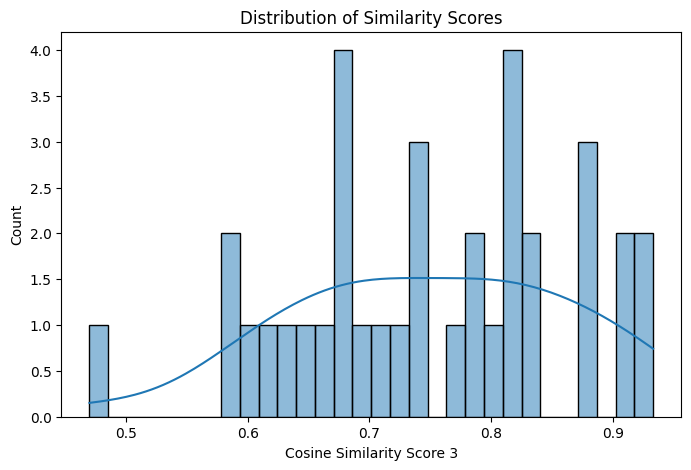

Average Cosine Similarity: 0.7475


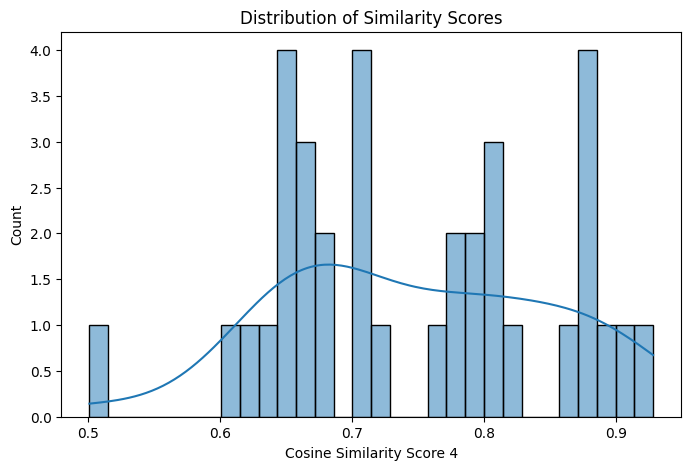

In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def add_emb(num):
    col_name = f"gpt_{num}_res_emb"
    test_df[col_name] = test_df[col_name].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
    similarity = f"similarity_{num}"
    test_df[similarity] = test_df.apply(lambda row: cosine_similarity([row["תוצאה מסכמת- embeddings"]], [row[col_name]])[0][0], axis=1)


    average_similarity = test_df[similarity].mean()
    print(f"Average Cosine Similarity: {average_similarity:.4f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(test_df[similarity], bins=30, kde=True)
    plt.xlabel(f"Cosine Similarity Score {num}")
    plt.ylabel("Count")
    plt.title("Distribution of Similarity Scores")
    plt.show()

add_emb(3)
add_emb(4)

In [ ]:
# high_sim_cases = test_df[test_df["similarity"] >= 0.8][["תוצאה מסכמת", "gpt_res"]]
# for index, row in high_sim_cases.iterrows():
#     print(f"**Case {index}:**")
#     print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
#     print(f"**GPT Summary:** {row['gpt_res']}")
#     print("-" * 100)


In [ ]:
def check_lows_sim(num):
    similarity = f"similarity_{num}"
    gpt_res = f"gpt_{num}_res"
    low_sim_cases = test_df[test_df[similarity] < 0.6][["תוצאה מסכמת", gpt_res]]
    print(f"GPT {num}:")
    for index, row in low_sim_cases.iterrows():
        print(f"**Case {index}:**")
        print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
        print(f"**GPT Summary:** {row[gpt_res]}")
        print("-" * 50)
    print("-" * 100)
check_lows_sim(3)
check_lows_sim(4)

GPT 3:
**Case 1328:**
**Original Text:** ״הבקשה נדחית״
**GPT Summary:** המבקש, זינובי שומכר, הגיש ערעור על פסק דין של בית המשפט המחוזי חיפה, והוחלט על ידי בית המשפט העליון שלא תינתן רשות ערעור במקרה כזה, מאחר שהמקרה לא מתאים לדיון בשאלה עקרונית. הבקשה נדחית והחלטת הבית המשפט ניתנה בתאריך 2.2.2022.
--------------------------------------------------
**Case 2925:**
**Original Text:** שאר חלקי גזרהדין יעמדו בעינם.
**GPT Summary:** ניתן רשות ערעור בעניין הארכת המועד לביצוע צו ההריסה, ובהסכמת המדינה נבטלות החלטות בתי המשפט התחתונים המתייחסות לזמן לביצוע ההריסה. ההחלטה מונעה את הארכת המועד על ידי בתי המשפט התחתונים ודורשת ביצוע הצו ללא הארכה.
--------------------------------------------------
**Case 3035:**
**Original Text:** הערות תוצאת ערעור
**GPT Summary:** ההחלטה המשפטית אושרה לערעור והחלטת בית המשפט המחוזי בתל אביב-יפו מתבטלת. הדיון יוחזר לבית המשפט המחוזי לפסוק בעניין תוך הנמקה של החלטתו.
--------------------------------------------------
------------------------------------------------

In [ ]:
df = pd.merge(df, check_gender_bias, on="מספר הליך", how="left", suffixes=('', '_dup'))

df = df.loc[:, ~df.columns.str.endswith('_dup')]


In [ ]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר'],
      dtype='object')

In [ ]:
import openai
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast


ניתוח סטטיסטי על הקשר בין מספר השופטים לבין שיעור קבלת בקשות לרשות ערעור.


<Figure size 1000x600 with 0 Axes>

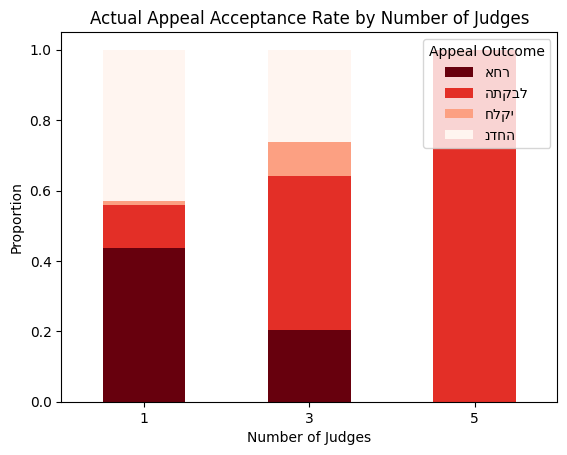

Chi-Square Test: p-value = 0.0000
A statistically significant relationship exists between the number of judges and appeal acceptance.


In [ ]:
# Ensure 'מגדר' column is properly formatted as a list
def safe_eval(value):
    """ Convert string representation of a list to an actual list safely. """
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Convert string to list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None
    elif isinstance(value, list):
        return value
    else:
        return None  # If it's NaN or other type, return None

df["מגדר"] = df["מגדר"].apply(safe_eval)

# Drop rows where we don't have judge information
df = df[df["מגדר"].notna()]

# Create a new column for number of judges
df["num_judges"] = df["מגדר"].apply(len)


df = df[df["num_judges"] > 0]


# Count occurrences of appeal acceptance based on number of judges
real_counts = df.groupby("num_judges")["בקשה לרשות ערעור התקבלה?"].value_counts().unstack().fillna(0)

# Plot real data
plt.figure(figsize=(10, 6))
real_counts.div(real_counts.sum(axis=1), axis=0).plot(kind="bar", stacked=True, colormap="Reds_r")
plt.title("Actual Appeal Acceptance Rate by Number of Judges")
plt.xlabel("Number of Judges")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="Appeal Outcome")
plt.show()

# Chi-Square test to check statistical significance
chi2, p_value, _, _ = stats.chi2_contingency(real_counts)
print(f"Chi-Square Test: p-value = {p_value:.4f}")

# Interpretation
if p_value > 0.05:
    print("No statistically significant relationship between the number of judges and appeal acceptance.")
else:
    print("A statistically significant relationship exists between the number of judges and appeal acceptance.")


In [ ]:
# def gpt_explain_patterns(case_text, model):
#     """ שולח את ההחלטה של הערעור ל-GPT כדי להסביר את הנימוקים המשפטיים מאחוריה. """
#     response = client.chat.completions.create(
#         model=model,
#         messages=[
#             {"role": "system", "content": "אתה מומחה משפטי. הסבר את הנימוקים מאחורי ההחלטה במקרה הנתון."},
#             {"role": "user", "content": f"Case Decision: {case_text}\n\nמהם הגורמים המרכזיים המשפיעים על ההחלטה?"}
#         ]
#     )
#     return response.choices[0].message.content

# # יצירת עמודות נפרדות להסברים מ-GPT-3 ול-GPT-4
# df["model_patterns_gpt3"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-3.5-turbo"))
# df["model_patterns_gpt4"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-4-turbo"))

# # הצגת דוגמאות ראשונות
# print(df[["בקשה לרשות ערעור התקבלה?", "model_patterns_gpt3", "model_patterns_gpt4"]].head())


In [ ]:
# import pandas as pd
# import scipy.stats as stats

# def evaluate_model_predictions(df, model_col, true_col, num_judges_col):
#     """
#     בודק האם יש קשר בין מספר השופטים להחלטת הערעור בתחזיות המודל לעומת הנתונים האמיתיים.

#     :param df: DataFrame עם הנתונים המשפטיים
#     :param model_col: שם העמודה עם תחזיות המודל
#     :param true_col: שם העמודה עם תוצאות הערעור האמיתיות
#     :param num_judges_col: שם העמודה עם מספר השופטים
#     :return: None (מדפיס תוצאות)
#     """
#     # חישוב מספר השופטים בפועל
#     df["num_judges"] = df[num_judges_col].apply(len)

#     # יצירת עמודת תחזיות – האם הערעור התקבל על בסיס התשובות של המודל
#     df[f"{model_col}_predicted_outcome"] = df[model_col].apply(lambda x: "התקבל" if "ערעור התקבל" in x else "נדחה")

#     # יצירת טבלת שכיחות - השוואת תוצאות אמיתיות מול תחזיות המודל
#     comparison_table = df.groupby("num_judges")[[true_col, f"{model_col}_predicted_outcome"]].value_counts().unstack()
#     comparison_table.fillna(0, inplace=True)

#     # בדיקת מתאם סטטיסטי בין מספר השופטים לבין קבלת הערעור בתחזיות המודל
#     chi2, p_value, _, _ = stats.chi2_contingency(comparison_table)
#     print(f"Chi-Square Test ({model_col} Predictions): p-value = {p_value:.4f}")

#     if p_value > 0.05:
#         print(f"המודל {model_col} לא למד את הדפוס בין מספר השופטים לקבלת הערעור.")
#     else:
#         print(f"המודל {model_col} הצליח ללמוד את הדפוס בין מספר השופטים לקבלת הערעור.")

# # הרצת הבדיקה עבור GPT-3
# evaluate_model_predictions(df, "model_patterns_gpt3", "בקשה לרשות ערעור התקבלה?", "מגדר")

# # הרצת הבדיקה עבור GPT-4
# evaluate_model_predictions(df, "model_patterns_gpt4", "בקשה לרשות ערעור התקבלה?", "מגדר")


In [ ]:
# Load test dataset
def load_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

test_data = load_jsonl("test.jsonl")

In [ ]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb', 'similarity_3', 'similarity_4'],
      dtype='object')

### Factuality / faithfulness

In [ ]:
import pandas as pd
import re
from tqdm import tqdm

# פונקציה להערכת האמינות
def evaluate_factuality(original_text, generated_summary, model="gpt-4-turbo"):
    """
    מעריך את מידת הנאמנות של הסיכום לטקסט המקורי בסקאלה של 1-5.
    המודל מחזיר מספר בלבד.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": 'אתה מומחה משפטי. דרג את מידת הנאמנות של התקציר לטקסט המקורי בסולם של 1-5, כאשר 5 הוא הנאמנות הגבוהה ביותר. השב **רק עם מספר בודד** ללא טקסט נוסף.'},
                {"role": "user", "content": f"פסק דין: {original_text}\n\nסיכום: {generated_summary}\n\nעד כמה הסיכום מדויק ונאמן למקור?"}
            ]
        )
        return response.choices[0].message.content.strip()  # מחזיר את הטקסט כמות שהוא
    except Exception as e:
        print(f"Error processing case: {e}")
        return None  # במקרה של שגיאה נחזיר None

# פונקציה לחילוץ מספר מהתשובה
def extract_score(response_text):
    """ מחלץ מספר מתוך תשובת המודל """
    match = re.search(r'\b[1-5]\b', response_text)  # מחפש מספר בין 1 ל-5
    return int(match.group()) if match else None  # מחזיר את המספר אם נמצא, אחרת None

# הוספת tqdm להתקדמות הביצוע
tqdm.pandas()

# בדיקת האמינות על 5 דוגמאות ראשונות לכל מודל
faithfulness_scores_gpt3 = []
faithfulness_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    faithfulness_gpt3 = extract_score(evaluate_factuality(original_text, row["gpt_3_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt3.append(faithfulness_gpt3)

    # הערכת נאמנות עבור gpt_4
    faithfulness_gpt4 = extract_score(evaluate_factuality(original_text, row["gpt_4_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt4.append(faithfulness_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text)
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Faithfulness Score (GPT-3): {faithfulness_gpt3}")
    print(f"Faithfulness Score (GPT-4): {faithfulness_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
avg_faithfulness_gpt3 = sum(score for score in faithfulness_scores_gpt3 if score is not None) / len(faithfulness_scores_gpt3)
avg_faithfulness_gpt4 = sum(score for score in faithfulness_scores_gpt4 if score is not None) / len(faithfulness_scores_gpt4)

print(f"\nAverage Faithfulness Score (GPT-3 Fine-Tuned): {avg_faithfulness_gpt3:.2f}")
print(f"Average Faithfulness Score (GPT-4 Fine-Tuned): {avg_faithfulness_gpt4:.2f}")


 20%|██        | 1/5 [00:01<00:05,  1.34s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
GPT-4 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------


 40%|████      | 2/5 [00:02<00:04,  1.39s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעבורה לדיון מחודש.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 4386/08: הבקשה לרשות ערעור מתקבלת לאור הסכמת הצדדים כ

 60%|██████    | 3/5 [00:04<00:03,  1.54s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
GPT-3 Summary: הבקשה לרשות ערעור נדחתה בהתאם לחלטת בית המשפט העליון, שניתנה בתאריך 18.8.2014.
GPT-4 Summary: בהחלטה שניתנה בתיק רע"פ 4137/14 בבית המשפט העליון, המבקשת ידיעות תקשורת בע"מ ביקשה רשות לערער על פסק דינו של בית המשפט המחוזי בבאר שבע מתאריך ה-5.6.2014. ההחלטה בבקשה נדחתה לעיון נוסף והחלטה סופית.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
------------------------

 80%|████████  | 4/5 [00:06<00:01,  1.64s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט

100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הבקשה לשינוי מועד הגשה נדחתה, ותגובת המדינה תוגש בתאריך 24.3.13.
GPT-4 Summary: בתיק רע"פ 5340/12, ניתנה החלטה לאשר את בקשת המבקש, אנטולי צבישב, לשינוי מועד הגשת תגובת המדינה לתאריך 24.3.13. לא נראה לשופטים כי יש צורך בתגובה נוספת מטעם המבקש.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------

Average Faithfulness Score (GPT-3 Fine-Tuned): 4.20
Average Faithfulness Score (GPT-4 Fine-Tuned): 5.00


#### BLEU & ROUGE

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# אתחול tqdm
tqdm.pandas()

# אתחול מחלקת ROUGE
rouge = Rouge()

# רשימות לאיסוף ציונים
bleu_scores_gpt3, rouge_scores_gpt3 = [], []
bleu_scores_gpt4, rouge_scores_gpt4 = [], []

# חישוב BLEU ו-ROUGE עבור 10 פסקי דין ראשונים
for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    reference_summary = row["תוצאה מסכמת"]  # הסיכום שנכתב ע"י המשפטנים
    gpt3_summary = row["gpt_3_res"]
    gpt4_summary = row["gpt_4_res"]

    # המרת משפטים לרשימות מילים עבור BLEU
    reference_tokens = reference_summary.split()
    gpt3_tokens = gpt3_summary.split()
    gpt4_tokens = gpt4_summary.split()

    # חישוב BLEU עם smoothing (למנוע 0 בתוצאות קצרות)
    smoothie = SmoothingFunction().method1
    bleu_gpt3 = sentence_bleu([reference_tokens], gpt3_tokens, smoothing_function=smoothie)
    bleu_gpt4 = sentence_bleu([reference_tokens], gpt4_tokens, smoothing_function=smoothie)

    # חישוב ROUGE
    rouge_gpt3 = rouge.get_scores(gpt3_summary, reference_summary)[0]
    rouge_gpt4 = rouge.get_scores(gpt4_summary, reference_summary)[0]

    # שמירת ציונים לרשימות
    bleu_scores_gpt3.append(bleu_gpt3)
    rouge_scores_gpt3.append(rouge_gpt3["rouge-l"]["f"])
    bleu_scores_gpt4.append(bleu_gpt4)
    rouge_scores_gpt4.append(rouge_gpt4["rouge-l"]["f"])

    # הדפסת תוצאות לכל מקרה
    print("=" * 60)
    print(f"פסק דין {i+1}:")
    print("-" * 60)
    print(" סיכום המשפטנים:", reference_summary)
    print("\nGPT-3 סיכום:", gpt3_summary)
    print(f"BLEU (GPT-3): {bleu_gpt3:.4f} | ROUGE-L (GPT-3): {rouge_gpt3['rouge-l']['f']:.4f}")
    print("\n GPT-4 סיכום:", gpt4_summary)
    print(f"BLEU (GPT-4): {bleu_gpt4:.4f} | ROUGE-L (GPT-4): {rouge_gpt4['rouge-l']['f']:.4f}")
    print("=" * 60)

# חישוב ממוצע ציונים לכל מודל
avg_bleu_gpt3 = np.mean(bleu_scores_gpt3)
avg_rouge_gpt3 = np.mean(rouge_scores_gpt3)
avg_bleu_gpt4 = np.mean(bleu_scores_gpt4)
avg_rouge_gpt4 = np.mean(rouge_scores_gpt4)

# הדפסת ממוצע כולל
print("\n📊 **ממוצע ציונים לכל מודל:**")
print(f" **BLEU ממוצע (GPT-3):** {avg_bleu_gpt3:.4f} | **ROUGE-L ממוצע (GPT-3):** {avg_rouge_gpt3:.4f}")
print(f" **BLEU ממוצע (GPT-4):** {avg_bleu_gpt4:.4f} | **ROUGE-L ממוצע (GPT-4):** {avg_rouge_gpt4:.4f}")


100%|██████████| 10/10 [00:00<00:00, 410.00it/s]

פסק דין 2552:
------------------------------------------------------------
 סיכום המשפטנים: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

GPT-3 סיכום: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
BLEU (GPT-3): 0.0731 | ROUGE-L (GPT-3): 0.3673

 GPT-4 סיכום: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
BLEU (GPT-4): 0.1623 | ROUGE-L (GPT-4): 0.4490
פסק דין 3005:
------------------------------------------------------------
 סיכום המשפטנים: ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

GPT-3 סיכום: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעב

#### NTI

In [ ]:


# פונקציה לבדיקת הגינות ונאמנות בשיטת NLI
def check_nli_fairness(model_name, original_text, generated_summary):
    """
    בודקת האם הסיכום תואם לטקסט המשפטי, ניטרלי או מכיל סתירות.

    :param model_name: שם המודל (gpt_3 או gpt_4)
    :param original_text: הטקסט המשפטי המלא
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: תוצאה - "נתמך", "ניטרלי" או "סתירה"
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה למשפטים ולניתוח לשוני. בדוק האם הסיכום תואם לחלוטין לפסק הדין המקורי, כולל ההשלכות המשפטיות."},
                {"role": "user", "content": f"טקסט משפטי: {original_text}\n\nסיכום המודל: {generated_summary}\n\nהאם הסיכום נתמך במלואו בטקסט המקורי, ניטרלי (כולל מידע נוסף), או מכיל סתירות?"}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה בבדיקת NLI ({model_name}): {e}")
        return None

# הוספת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה על 10 פסקי דין ראשונים
nli_results_gpt3 = []
nli_results_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]
    reference_summary = row["תוצאה מסכמת"]  # הסיכום שנכתב ע"י משפטנים
    gpt3_summary = row["gpt_3_res"]
    gpt4_summary = row["gpt_4_res"]

    # בדיקת NLI עבור GPT-3
    nli_gpt3 = check_nli_fairness(gpt_3, original_text, gpt3_summary)
    nli_results_gpt3.append(nli_gpt3)

    # בדיקת NLI עבור GPT-4
    nli_gpt4 = check_nli_fairness(gpt_4, original_text, gpt4_summary)
    nli_results_gpt4.append(nli_gpt4)

    # הדפסת תוצאות לכל מקרה
    print("=" * 60)
    print(f"פסק דין {i+1}:")
    print("-" * 60)
    print("🔹 סיכום המשפטנים:", reference_summary)
    print("\n🔹 GPT-3 סיכום:", gpt3_summary)
    print(f"NLI (GPT-3): {nli_gpt3}")
    print("\n🔹 GPT-4 סיכום:", gpt4_summary)
    print(f"NLI (GPT-4): {nli_gpt4}")
    print("=" * 60)

# ספירת מספר המקרים לכל קטגוריה
nli_counts_gpt3 = pd.Series(nli_results_gpt3).value_counts()
nli_counts_gpt4 = pd.Series(nli_results_gpt4).value_counts()

# הדפסת סיכום
print("\n **תוצאות סופיות של NLI:**")
print("\n **GPT-3**")
print(nli_counts_gpt3)
print("\n **GPT-4**")
print(nli_counts_gpt4)


 10%|█         | 1/10 [00:02<00:24,  2.68s/it]

פסק דין 2552:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

🔹 GPT-3 סיכום: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
NLI (GPT-3): הסיכום נתמך במלואו בטקסט המקורי.

🔹 GPT-4 סיכום: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
NLI (GPT-4): נראה שהסיכום תואם לחלוטין לפסק הדין המקורי.


 20%|██        | 2/10 [00:04<00:19,  2.41s/it]

פסק דין 3005:
------------------------------------------------------------
🔹 סיכום המשפטנים: ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

🔹 GPT-3 סיכום: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעבורה לדיון מחודש.
NLI (GPT-3): הסיכום נתון בצורה ניטרלית ומדווח בצורה מדויקה ובלבד של החלטת בית הערעור העליון. אין בו סתירות.

🔹 GPT-4 סיכום: החלטת בית המשפט העליון בתיק רע"פ 4386/08: הבקשה לרשות ערעור מתקבלת לאור הסכמת הצדדים כמפורט בתגובת המשיבה. פסקי הדין שניתנו על ידי בית המשפט המחוזי בירושלים בעניינו של המבקש מבוטלים, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)
הסיכום כולל גם את הבקשה וגם את הערעור.


 30%|███       | 3/10 [00:06<00:13,  1.95s/it]

פסק דין 3371:
------------------------------------------------------------
🔹 סיכום המשפטנים: נדחה לעיון ולהחלטה

🔹 GPT-3 סיכום: הבקשה לרשות ערעור נדחתה בהתאם לחלטת בית המשפט העליון, שניתנה בתאריך 18.8.2014.
NLI (GPT-3): הסיכום תואם לטקסט המקורי.

🔹 GPT-4 סיכום: בהחלטה שניתנה בתיק רע"פ 4137/14 בבית המשפט העליון, המבקשת ידיעות תקשורת בע"מ ביקשה רשות לערער על פסק דינו של בית המשפט המחוזי בבאר שבע מתאריך ה-5.6.2014. ההחלטה בבקשה נדחתה לעיון נוסף והחלטה סופית.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)


 40%|████      | 4/10 [00:09<00:13,  2.26s/it]

פסק דין 2650:
------------------------------------------------------------
🔹 סיכום המשפטנים: דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו

🔹 GPT-3 סיכום: ההחלטה המשפטית בפסק דין רע"פ 9608/01 מבית המשפט העליון הייתה כי המדינה הגישה ערעור על פסק-דין שביטל כתב אישום כנגד המבקשים. הבית המשפט העליון החזיר את הדיון לבית המשפט לעניינים מקומיים להמשך בירור המשפטי. המשפט קבע כי עדיין לא ניתן לדון בטענות המבקשים ושהם יכולים לפנות שוב לבית המשפט במידת הצורך לאחר שימוצו ההליכים בבתי המשפט התחתונים.
NLI (GPT-3): הסיכום מביא ביטוי לכך שהבקשה נמחקה מהם, אבל בסופו של דבר נכנס ב ופט.

🔹 GPT-4 סיכום: בית המשפט העליון דחה את בקשת רשות ערעור שהוגשה על ידי המבקשים נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים והחזירה את הדיון בתיק לבית המשפט לעניינים

 50%|█████     | 5/10 [00:10<00:09,  1.96s/it]

פסק דין 2972:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה לשנוי מועד הגשה

🔹 GPT-3 סיכום: הבקשה לשינוי מועד הגשה נדחתה, ותגובת המדינה תוגש בתאריך 24.3.13.
NLI (GPT-3): הסיכום מסתמך במלואו בטקסט המקורי.

🔹 GPT-4 סיכום: בתיק רע"פ 5340/12, ניתנה החלטה לאשר את בקשת המבקש, אנטולי צבישב, לשינוי מועד הגשת תגובת המדינה לתאריך 24.3.13. לא נראה לשופטים כי יש צורך בתגובה נוספת מטעם המבקש.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)


 60%|██████    | 6/10 [00:14<00:10,  2.62s/it]

פסק דין 929:
------------------------------------------------------------
🔹 סיכום המשפטנים: אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה

🔹 GPT-3 סיכום: ההחלטה המשפטית היא לקבל את בקשת רשות הערעור בקשר להוצאות שהוטלו על המבקש במשפט הפלילי. בית המשפט המחוזי החליט להטיל עליו הוצאות על פי דיני תכנון ובניה, אך בהתווי על כך נגדו סנקציה כבקשת רשות הערעור. המשפט העליון הקביל את ההחלטה של בית המשפט המחוזי וקבע כי אין כאן ראיות כדי להטל הוצאות על המבקש, מבלי להעריכם היטב. לפיכך, החלטת בית המשפט המחוזי להטל הוצאות מבוטלת ובקשת רשות הערעור מתקבלת חלקית.
NLI (GPT-3): בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים.

🔹 GPT-4 סיכום: הערעור שהוגש על פי רשות נתקבל בקשר להוצאות שהוטלו על המבקש בבית המ

 70%|███████   | 7/10 [00:20<00:11,  3.83s/it]

פסק דין 1329:
------------------------------------------------------------
🔹 סיכום המשפטנים: ״הבקשה נדחית״

🔹 GPT-3 סיכום: המבקש, זינובי שומכר, הגיש ערעור על פסק דין של בית המשפט המחוזי חיפה, והוחלט על ידי בית המשפט העליון שלא תינתן רשות ערעור במקרה כזה, מאחר שהמקרה לא מתאים לדיון בשאלה עקרונית. הבקשה נדחית והחלטת הבית המשפט ניתנה בתאריך 2.2.2022.
NLI (GPT-3): סיכום המודל נתמך בטקסט המקורי.

🔹 GPT-4 סיכום: בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על פסק דין מבית המשפט המחוזי. החלטתו מבוססת על כך שאף שהבקשה עשויה להעלות שאלה עקרונית, המקרה עצמו אינו מתאים לדיון בשאלה זו עקב אופן התנהלות ההליכים בערכאה הקמא ומשקל הטענות שהועלו שם. הבקשה נדחית ללא ביקורת על הסנגוריה, אלא מתוך הכרה במציאות הנתונה בהליך.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)


 80%|████████  | 8/10 [00:24<00:07,  3.79s/it]

פסק דין 2951:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.

🔹 GPT-3 סיכום: המבקש מאושר לבצע את ששת חודשי המאסר שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, לפי המסגרת שנקבעה בחוות-דעת הממונה על עבודות השירות.
NLI (GPT-3): נראה שהמבקש התחייב לעבוד בעבודות שירות באגודה למען הקשיש יקנעם וקיבלו את הבקשה.

🔹 GPT-4 סיכום: החלטת בית המשפט העליון ברע"פ 11363/03 מעניקה את הרשות לערעור על פסק-דינו של בית-המשפט המחוזי בחיפה, וקובעת כי המבקש יבצע את ששת חודשי המאסר הנדרשים ממנו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית, בהתאם לתכנית שנקבעה בחוות דעת הממונה על עבודות השירות. המבקש יתחיל בריצוי עונשו ב-1.11.2004.
NLI (GPT-4): נראה שהסיכום כולל טעות: "החלטת בית המשפט העליון ברע"פ 11363/03 מעניקה את הרשו

 90%|█████████ | 9/10 [00:26<00:03,  3.11s/it]

פסק דין 1941:
------------------------------------------------------------
🔹 סיכום המשפטנים: סוף דבר אין בידי להיעתר לבקשה

🔹 GPT-3 סיכום: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי בנושא תאונה דרכים נדחתה על כך שאין בה צורך לברר שאלות משפטיות בעלות השלכה כללית, והטענות הועלו ונדחו בגופן במערכת המשפט.
NLI (GPT-3): הסיכום נתמך במלואו בטקסט המקורי.

🔹 GPT-4 סיכום: בקשת רשות הערעור שהגיש המבקש נדחתה על ידי בית המשפט העליון. הנימוק לדחייה הוא שבקשות רשות ערעור בגלגול שלישי מיועדות לבחינת שאלות משפטיות עקרוניות בעלות השלכה כללית, ולא לתיקוני פגמים בניהול ההוכחות או הליך במקרה פרטני. במקרה זה, טענות המבקש נדחו על ידי בית המשפט המחוזי והופנו כלפי הראיות והליכי המשפט בתיק ספציפי זה, ולא לנושאים עקרוניים שיבצעו שינוי כללי במערכת המשפט. השופט ציין שכללי המשפט מעניקים לנאשם שני "ימי משפט" - הדיון והערעור, ולכן יום שלישי של שיפוט הוא קשה להצדקה ושמור לשיקולים בעלי טיב עקרוני וכללי בלבד.
NLI (GPT-4): נראה שהסיכום תואם במלואו לטקסט המקורי.


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

פסק דין 3859:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

🔹 GPT-3 סיכום: ההחלטה המשפטית ברע"פ 2100/03 קובעת כי אין מקום לדחיית מועד ביצוע מאסר, ולכן הבקשה לדחייה נדחתה.
NLI (GPT-3): כן, הסיכום מדויק ונתמך במלואו בטקסט המקורי.

🔹 GPT-4 סיכום: בתיק רע"פ 2100/03, המבקש, דוד בן יעקב תמם, ביקש לדחות את מועד ביצוע עונש המאסר. בית המשפט העליון, בפסק הדין שניתן על ידי השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש, ולכן הבקשה נדחית. ההחלטה ניתנה ביום 6 במאי 2003.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)

📊 **תוצאות סופיות של NLI:**

🔹 **GPT-3**
הסיכום נתמך במלואו בטקסט המקורי.                                                                                         2
הסיכום נתון בצורה ניטרלית ומדווח בצורה מדויקה ובלבד של החלטת בית הערעור העליון. אין בו סתירות.                           1
הסיכום תואם לטקסט המקורי.                                                                                              

In [1024]:

from collections import Counter
import IPython.display as display

# פונקציה לבדיקת נאמנות והגינות באמצעות מודל NLI
def check_nli_faithfulness(model_name, original_text, generated_summary):
    """
    בודקת האם הסיכום שנוצר אכן משקף את ההחלטה המשפטית המקורית.

    :param model_name: שם המודל שישמש לבדיקה (GPT-4, GPT-3 וכו')
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר מהמודל
    :return: קטגוריית NLI (Entailment, Contradiction, Neutral)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. קבע האם הסיכום הבא משקף את המשמעות המשפטית של פסק הדין או מכיל מידע שגוי."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\n\nסיכום: {generated_summary}\n\nהאם הסיכום נכון מבחינה משפטית? בחר אחת מהאפשרויות: 'Entailment' אם הסיכום נכון, 'Contradiction' אם הסיכום שגוי, או 'Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין."}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה בבדיקת NLI ({model_name}): {e}")
        return None

# יצירת רשימות לאחסון התוצאות
nli_results_gpt3 = []
nli_results_gpt4 = []

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה והשוואה בין המודלים על 10 דוגמאות
for i, row in tqdm(test_df.iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]
    reference_summary = row["תוצאה מסכמת"]

    # בדיקת נאמנות עבור GPT-3
    nli_gpt3 = check_nli_faithfulness(gpt_3, original_text, row["gpt_3_res"])
    nli_results_gpt3.append(nli_gpt3)

    # בדיקת נאמנות עבור GPT-4
    nli_gpt4 = check_nli_faithfulness(gpt_4, original_text, row["gpt_4_res"])
    nli_results_gpt4.append(nli_gpt4)

    # הצגת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Reference Summary (By Research Assistants):", reference_summary)
    print("\nFine-Tuned GPT-3 Summary:", row["gpt_3_res"])
    print("NLI Result (GPT-3):", nli_gpt3)
    print("\nFine-Tuned GPT-4 Summary:", row["gpt_4_res"])
    print("NLI Result (GPT-4):", nli_gpt4)
    print("-------------------------------------------------")

# חישוב סטטיסטיקות של NLI לכל מודל
nli_counts_gpt3 = Counter(nli_results_gpt3)
nli_counts_gpt4 = Counter(nli_results_gpt4)



 10%|█         | 1/10 [00:02<00:18,  2.03s/it]


Case 2552:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

Fine-Tuned GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
NLI Result (GPT-4): Entailment
-------------------------------------------------


 20%|██        | 2/10 [00:09<00:41,  5.20s/it]


Case 3005:
Reference Summary (By Research Assistants): ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

Fine-Tuned GPT-3 Summary: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעבורה לדיון מחודש.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 4386/08: הבקשה לרשות ערעור מתקבלת לאור הסכמת הצדדים כמפורט בתגובת המשיבה. פסקי הדין שניתנו על ידי בית המשפט המחוזי בירושלים בעניינו של המבקש מבוטלים, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו.
NLI Result (GPT-4): Entailment
-------------------------------------------------


 30%|███       | 3/10 [00:10<00:23,  3.40s/it]


Case 3371:
Reference Summary (By Research Assistants): נדחה לעיון ולהחלטה

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור נדחתה בהתאם לחלטת בית המשפט העליון, שניתנה בתאריך 18.8.2014.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בהחלטה שניתנה בתיק רע"פ 4137/14 בבית המשפט העליון, המבקשת ידיעות תקשורת בע"מ ביקשה רשות לערער על פסק דינו של בית המשפט המחוזי בבאר שבע מתאריך ה-5.6.2014. ההחלטה בבקשה נדחתה לעיון נוסף והחלטה סופית.
NLI Result (GPT-4): Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין.'
-------------------------------------------------


 40%|████      | 4/10 [00:12<00:16,  2.67s/it]


Case 2650:
Reference Summary (By Research Assistants): דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית בפסק דין רע"פ 9608/01 מבית המשפט העליון הייתה כי המדינה הגישה ערעור על פסק-דין שביטל כתב אישום כנגד המבקשים. הבית המשפט העליון החזיר את הדיון לבית המשפט לעניינים מקומיים להמשך בירור המשפטי. המשפט קבע כי עדיין לא ניתן לדון בטענות המבקשים ושהם יכולים לפנות שוב לבית המשפט במידת הצורך לאחר שימוצו ההליכים בבתי המשפט התחתונים.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות ערעור שהוגשה על ידי המבקשים נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים והחזירה את הדיון בתיק לבית המשפט לעניינים מקומיים. העליון ציין כי עד שלא יושלם ההליך בערכאה הראשונה ואז במחוזי

 50%|█████     | 5/10 [00:13<00:10,  2.14s/it]


Case 2972:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לשנוי מועד הגשה

Fine-Tuned GPT-3 Summary: הבקשה לשינוי מועד הגשה נדחתה, ותגובת המדינה תוגש בתאריך 24.3.13.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 5340/12, ניתנה החלטה לאשר את בקשת המבקש, אנטולי צבישב, לשינוי מועד הגשת תגובת המדינה לתאריך 24.3.13. לא נראה לשופטים כי יש צורך בתגובה נוספת מטעם המבקש.
NLI Result (GPT-4): Neutral
-------------------------------------------------


 60%|██████    | 6/10 [00:15<00:08,  2.01s/it]


Case 929:
Reference Summary (By Research Assistants): אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית היא לקבל את בקשת רשות הערעור בקשר להוצאות שהוטלו על המבקש במשפט הפלילי. בית המשפט המחוזי החליט להטיל עליו הוצאות על פי דיני תכנון ובניה, אך בהתווי על כך נגדו סנקציה כבקשת רשות הערעור. המשפט העליון הקביל את ההחלטה של בית המשפט המחוזי וקבע כי אין כאן ראיות כדי להטל הוצאות על המבקש, מבלי להעריכם היטב. לפיכך, החלטת בית המשפט המחוזי להטל הוצאות מבוטלת ובקשת רשות הערעור מתקבלת חלקית.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: הערעור שהוגש על פי רשות נתקבל בקשר להוצאות שהוטלו על המבקש בבית המשפט המחוזי, ונקבע שהוצאות אלו לא ידרשו ממנו. החלטה זו התקבלה בשל שגגה בזיהוי המבקש בהחלטות הקודמות שהובאו כטעם להטלת

 70%|███████   | 7/10 [00:17<00:05,  1.96s/it]


Case 1329:
Reference Summary (By Research Assistants): ״הבקשה נדחית״

Fine-Tuned GPT-3 Summary: המבקש, זינובי שומכר, הגיש ערעור על פסק דין של בית המשפט המחוזי חיפה, והוחלט על ידי בית המשפט העליון שלא תינתן רשות ערעור במקרה כזה, מאחר שהמקרה לא מתאים לדיון בשאלה עקרונית. הבקשה נדחית והחלטת הבית המשפט ניתנה בתאריך 2.2.2022.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על פסק דין מבית המשפט המחוזי. החלטתו מבוססת על כך שאף שהבקשה עשויה להעלות שאלה עקרונית, המקרה עצמו אינו מתאים לדיון בשאלה זו עקב אופן התנהלות ההליכים בערכאה הקמא ומשקל הטענות שהועלו שם. הבקשה נדחית ללא ביקורת על הסנגוריה, אלא מתוך הכרה במציאות הנתונה בהליך.
NLI Result (GPT-4): Entailment
-------------------------------------------------


 80%|████████  | 8/10 [00:18<00:03,  1.67s/it]


Case 2951:
Reference Summary (By Research Assistants): בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.

Fine-Tuned GPT-3 Summary: המבקש מאושר לבצע את ששת חודשי המאסר שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, לפי המסגרת שנקבעה בחוות-דעת הממונה על עבודות השירות.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: החלטת בית המשפט העליון ברע"פ 11363/03 מעניקה את הרשות לערעור על פסק-דינו של בית-המשפט המחוזי בחיפה, וקובעת כי המבקש יבצע את ששת חודשי המאסר הנדרשים ממנו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית, בהתאם לתכנית שנקבעה בחוות דעת הממונה על עבודות השירות. המבקש יתחיל בריצוי עונשו ב-1.11.2004.
NLI Result (GPT-4): Contradiction
-------------------------------------------------


 90%|█████████ | 9/10 [00:19<00:01,  1.45s/it]


Case 1941:
Reference Summary (By Research Assistants): סוף דבר אין בידי להיעתר לבקשה

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי בנושא תאונה דרכים נדחתה על כך שאין בה צורך לברר שאלות משפטיות בעלות השלכה כללית, והטענות הועלו ונדחו בגופן במערכת המשפט.
NLI Result (GPT-3): 'Contradiction'

Fine-Tuned GPT-4 Summary: בקשת רשות הערעור שהגיש המבקש נדחתה על ידי בית המשפט העליון. הנימוק לדחייה הוא שבקשות רשות ערעור בגלגול שלישי מיועדות לבחינת שאלות משפטיות עקרוניות בעלות השלכה כללית, ולא לתיקוני פגמים בניהול ההוכחות או הליך במקרה פרטני. במקרה זה, טענות המבקש נדחו על ידי בית המשפט המחוזי והופנו כלפי הראיות והליכי המשפט בתיק ספציפי זה, ולא לנושאים עקרוניים שיבצעו שינוי כללי במערכת המשפט. השופט ציין שכללי המשפט מעניקים לנאשם שני "ימי משפט" - הדיון והערעור, ולכן יום שלישי של שיפוט הוא קשה להצדקה ושמור לשיקולים בעלי טיב עקרוני וכללי בלבד.
NLI Result (GPT-4): Entailment
-------------------------------------------------


100%|██████████| 10/10 [00:20<00:00,  1.54s/it]


Case 3859:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית ברע"פ 2100/03 קובעת כי אין מקום לדחיית מועד ביצוע מאסר, ולכן הבקשה לדחייה נדחתה.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 2100/03, המבקש, דוד בן יעקב תמם, ביקש לדחות את מועד ביצוע עונש המאסר. בית המשפט העליון, בפסק הדין שניתן על ידי השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש, ולכן הבקשה נדחית. ההחלטה ניתנה ביום 6 במאי 2003.
NLI Result (GPT-4): Neutral
-------------------------------------------------


11it [00:22,  1.50s/it]                        


Case 1930:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי עונש המאסר
המדינה הודיעה כי היא אינה מתנגדת לבקשה ועל כן אני נעתרת לה ומורה על עיכוב ביצוע

Fine-Tuned GPT-3 Summary: המדינה מסכימה לבקשת עיכוב ביצוע רכיב המאסר של המבקש עד תאריך מסוים.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: ההחלטה בתיק רע"פ 7771/11 קובעת את עיכוב ביצוע רכיב המאסר של המבקש יוסף מראר, לפי ההסכמה של המדינה שלא להתנגד לבקשה. המבקש יתייצב לריצוי מאסרו לא ביום 30.10.2011 כפי שנקבע מקודם, אלא ביום 10.11.2011 עד השעה 12:00.
NLI Result (GPT-4): Neutral
-------------------------------------------------


12it [00:23,  1.35s/it]


Case 2349:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לעיון חוזר

Fine-Tuned GPT-3 Summary: הבקשה לעיון חוזר בתיק רע"פ 271/16 נדחתה, ככל שהשגה הנוגעת לתקינות בדיקת הינשוף לא הובילה לצורך בזמן נוסף לעדות עורכי התע"צ.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בתיק רע"פ 271/16, כבוד השופט א' שהם קבע כי מאחר שהמבקשת לא העלתה כל השגה בראשית ההליך לגבי תקינות בדיקת הינשוף שנערכה לה, אין מקום לזמן את עורכי הבדיקה להעיד, ולא לרשום אותם כעדים של המשיבה בכתב האישום. הבקשה לעיון חוזר נדחית.
NLI Result (GPT-4): Neutral
-------------------------------------------------


13it [00:24,  1.27s/it]


Case 2685:
Reference Summary (By Research Assistants): בקשה לערעור+עיכוב ביצוע

Fine-Tuned GPT-3 Summary: הבקשה לערעור על פסק הדין שהורשע בו המבקש בפרק 3 ושנדחתה בגלגול הקודם של ערעור מבוססת על טענה לא קיבלת דיון כדין ועילה כי עונשו המוטל עליו היה חמור במידה שמצדיקה את הערעור. בפרק 7 הוחלט כי אין בעניינו של המבקש סוגיית משמעותית המוצדקת ערעור בגלגול שני, ולכן הבקשה לערעור נדחית.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: במקרה דנן, המבקש עתר לבית המשפט העליון למתן רשות ערעור על פסק דין שניתן נגדו בערעור לבית המשפט המחוזי, שבו נדחה ערעורו על החלטת בית משפט השלום לתעבורה. המבקש הורשע בהיעדרו בעבירה של שימוש בטלפון נייד במהלך נהיגה שנגזר עליו עונש של קנס ופסילת רישיון. המבקש טען שלא זומן כדין לדיון ושהעונש הוא חמור מידי.

בית המשפט העליון דחה את בקשתו לרשות ערעור, כשהדגיש שרשות ערעור "בגלגול שלישי" ניתנת רק במקרים בעלי חשיבות ציבורית נרחבת או במקרה של חשש ממשי לעיוות דין. במקרה שלפנינו, הבקשה הייתה ממוקדת בענייניו הפרטני של המבקש ולא העלתה נושאים עקרוניים. בנוסף, בית המשפט 

14it [00:26,  1.47s/it]


Case 1975:
Reference Summary (By Research Assistants): מצאנו כי אין בתיקים שבפנינו, עילה להתערב בתוצאה אליה הגיעו בתי המשפט המחוזיים וממילא לא קמה עילה המצדיקה מתן רשות ערעור

Fine-Tuned GPT-3 Summary: הבית המשפט העליון קבע כי תוצאות מדידת האלכוהול במכשירי נשיפה נבחנות בדרך כפולה ועברו בדיקות אימות תקופתיות ויומיומיות. המכשירים נבדקו וכויילו על-פי מיכלי כיול, והם עברו בדיקה שהכילה גז יבש עם שיעור אלכוהול מקובל בריכוז של 350 מק"ג. על פי ההליך המקובל, אם התוצאות של מדידת הנשיפה חולפות את הערכים המוזנים למכשיר ביותר מחמש אחוזים נתקבלת התראה. כן נמצא כי אפשרות סטייה בבלוני הכיול נמצאת בתחום ההפעלה הנכון. בנוסף, מיכלי הגז המשמשים למדידת האלכוהול עברו בדיקות איכות תקפות ומוצרי היצרן משמשים במדינות אחרות. לכן, הבית המשפט קבע כי אין עילה מתקבלת לערעור ונדחתו את הבקשות.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בקשות למתן רשות ערעור נדחו. הבית המשפט העליון קבע כי אין עילה מצדיקה למתן רשות ערעור, על רקע אמינות מכשירי הנשיפה והתשתית הראייתית הקיימת. ההנחה שהמכשירים תקינים נתמכת בח

15it [00:27,  1.40s/it]


Case 1022:
Reference Summary (By Research Assistants): לאחר שעיינתי בבקשת רשות הערעור ובפסקי הדין של הערכאות הקודמות, נחה דעתי כי דין הבקשה להידחות

Fine-Tuned GPT-3 Summary: ההחלטה דחתה את בקשת רשות הערעור ואישרה את החלטת בית המשפט המחוזי, שהחליט להחזיר בחלק קטן את ערעור המבקש ולשמור על הכרעת בית המשפט השלום בקשר לתקרית בניידת המשטרה. ההחלטה התייחסה לנדרשות דיון נוסף בפני ערכאה שלישית במקרים שבהם טענות המבקש לא מעוררות סוגיה חשובה משפטית וכי ערעות ערעור אינן מתערבות בממצאים עבודתיים שנקבעו על ידי בית המשפט המקורי.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: הבקשה למתן רשות ערעור נדחתה, משום שלא הוצגה כל סוגיה בעלת חשיבות משפטית או ציבורית החורגת מעניינם הפרטני של הצדדים. הבקשה התמקדה בעיקה מרכזית נגד קביעה עובדתית-משפטית של הערכאה הדיונית, לפיה לא התקיים במצב דברים המקים את סייג ההגנה העצמית, ובהתאם לכללים, בית המשפט העליון אינו מתערב בממצאים עובדתיים אלא במקרים חריגים ביותר. המחוזי קבע כי הסיטואציה לא הייתה מאיימת כלפי המבקש במידה שמצדיקה תגובה חריפה, ושתגובת שוטר צריכה ל

16it [00:28,  1.42s/it]


Case 1908:
Reference Summary (By Research Assistants): הבקשה נמחקה
בכפוף לכך אנו מוחקים את הערעור.

Fine-Tuned GPT-3 Summary: הבית המשפט החליט לפי הסכמת הצדדים לבטל את הדיון. בהתאם לכך, הערעור נמחק.
NLI Result (GPT-3): Entailment

Fine-Tuned GPT-4 Summary: בתיק רע"פ 10106/04, לאור הודעה מוסכמת שהוגשה על ידי באי כוח הצדדים והבקשה לביטול הדיון הקבוע, בית המשפט העליון החליט למחוק את הערעור.
NLI Result (GPT-4): Entailment
-------------------------------------------------


17it [00:31,  1.62s/it]


Case 1272:
Reference Summary (By Research Assistants): ״סוף דבר, הבקשה נדחית״

Fine-Tuned GPT-3 Summary: הערעור על גזר דין הוקש בצורה חלקית על ידי בית המשפט המחוזי. המערער טען כי הענישה המוטלת עליו חמורה מדי, אך בית המשפט החליט כי הענישה עומדת בטווח המוסכם ולא הפר את הסדר הטיעון. למרות שהמערער הסיר את המחדלים וקיבל עונש מאסר בפועל, הוחלט להוריד את גובה הקנס שהוטל עליו. בית המשפט החליט כי לא קיים סמכות לערעור ב"גלגול שלישי" וכן כי הענישה שהוטלה עליו אינה יוצאת דופן ממדיניות הענישה הנפוצה. על רקע הנ"ל, הבקשה להידחת הערעור נדחתה.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: להידחות.
NLI Result (GPT-4): 'Entailment'
-------------------------------------------------


18it [00:32,  1.48s/it]


Case 912:
Reference Summary (By Research Assistants): הבקשה בתיק זה נמחקת איפוא. המשיב נפטר לעולמו זכאי
הבקשה נמחקה כי המשיב (הנאשם המקורי) נפטר

Fine-Tuned GPT-3 Summary: ההחלטה בתיק רע"פ 2891/10 היא לפסול את הבקשה לרשות ערעור, בעקבות פטירת המשיב. על פי סעיף 236 לחוק סדר הדין הפלילי, נפטר אדם לא ניתן להמשיך בליך פלילי נגדו. מאחר שהמשיב נפטר, הבקשה נמחקת והדיון סגור.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: החלטה בתיק רע"פ 2891/10 קובעת את ביטול ההליכים בעקבות פטירת המשיב, למידע המתבסס על סעיף 236 לחוק סדר הדין הפלילי שקובע כי במקרה של פטירת הנאשם ייפסקו כל ההליכים הפליליים נגדו. המשיב זכאי לכך והמדינה תצטרך לטפל בשאלה המשפטית העולה מהמקרה במסגרת אחרת.
NLI Result (GPT-4): Entailment
-------------------------------------------------


19it [00:33,  1.42s/it]


Case 3056:
Reference Summary (By Research Assistants): בנוסף צו העיכוב בטל
איני נעתר איפוא לבקשת רשות הערעור

Fine-Tuned GPT-3 Summary: בית המשפט העליון קבע כי אין בטענת השיהוי כדי להכריע לעבר אי מתן צו הפסקה במקרה דנא. בית המשפט המחוזי דחה את הערעור וביטל את צו העיכוב, והחליט שההפסקה תיכנס לתוקף בתוך 60 יום. בקשת הערעור הנוכחית נדחתה על כך שהסוגיות שהובאו הן פרטניות ואין שיקולי צדק ייחודיים שמצדיקים קבלת הבקשה. בית המשפט העליון קבע כי קיימת חובת המשפט להפסיק בניה בלתי חוקית, ושהאינטרס שלטון החוק גובר על האינטרס הפרטי של המבקש.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: בית המשפט דחה את בקשת המבקש למתן רשות ערעור כיוון שהנושאים העולים בקשתו הם פרטניים ולא עולים בקנה אחד עם סעיפי החוק הקובעים כי רשות ערעור תינתן במקרים של עניינים עקרוניים או ציבוריים. כמו כן, טענות המבקש כבר נדונו בערכאות השונות ונמצאו ללא בסיס. בנוסף, השופט ציין כי עבירות בנייה ללא היתר הן עבירות חמורות הנזקקות לטיפול משפטי מהיר ויעיל ולא יכולות להיגרר בהליכים משפטיים ארוכים. אין לקבוע למבקש רשות לערע

20it [00:35,  1.62s/it]


Case 2905:
Reference Summary (By Research Assistants): פס"ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר לדיון בביהמ"ש המחוזי בטענות לגופן

Fine-Tuned GPT-3 Summary: הבית המשפט העליון קיבל את ההסכמה של כל הצדדים והורה לבית המשפט המחוזי לבטל את ההחלטה הקודמת ולשוב על הדיון בתיק, כולל טענות שני הצדדים. נקבע כי עמדת היועץ המשפטי לממשלה תועבר לבית המשפט המחוזי. ההליך נסגר ללא צורך בהפנית צו להוצאות.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 3296/14, בית המשפט העליון קיבל את עמדת היועץ המשפטי לממשלה והחליט לבטל את פסק הדין של בית המשפט המחוזי לעניין הסמכות. הדיון יוחזר לבית המשפט המחוזי על מנת שיידון בטענות של שני הצדדים, כולל המבקש והמשיבים. העמדות תועברנה לבית המשפט המחוזי על ידי הצדדים. ההליך בבית המשפט העליון מסתיים ללא צו להוצאות.
NLI Result (GPT-4): Neutral
הסיכום מתייחס לחלק מהמקרה בלבד, והוא החזרת התיק לבית המשפט המחוזי.
-------------------------------------------------


21it [00:36,  1.48s/it]


Case 3068:
Reference Summary (By Research Assistants): הערעור על חומרת העונש מתקבל בחלקו

Fine-Tuned GPT-3 Summary: הבקשה לערעור מתקבלת ועונש המשוערך של המבקש מתוקף ב-7 חודשים, והוא מורכב כעת מ-18 חודשי מאסר בפועל.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתוקף בקשה מוסכמת, נתקבל ערעור המבקש, יצחק בוסקילה, לגבי חומרת העונש שנגזר עליו, על פי הודאתו בבית משפט השלום בתל אביב, בעבירות של התפרצות לדירת מגורים וגניבה. בהתחשב במצבו הבריאותי שהחמיר, הוחלט לחילוי מוחלט של שני המאסרים המותנים שהופעלו עליו עם העונש המקורי שנגזר עליו. על כן, האסיר ירצה בפועל 18 חודשי מאסר שימנו מיום מעצרו ב-5.5.2013. הדיון שהיה אמור להתקיים מחר, בוטל.
NLI Result (GPT-4): Entailment
-------------------------------------------------


22it [00:37,  1.38s/it]


Case 2926:
Reference Summary (By Research Assistants): שאר חלקי גזרהדין יעמדו בעינם.

Fine-Tuned GPT-3 Summary: ניתן רשות ערעור בעניין הארכת המועד לביצוע צו ההריסה, ובהסכמת המדינה נבטלות החלטות בתי המשפט התחתונים המתייחסות לזמן לביצוע ההריסה. ההחלטה מונעה את הארכת המועד על ידי בתי המשפט התחתונים ודורשת ביצוע הצו ללא הארכה.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בהחלטת בית המשפט העליון ניתנה רשות לערעור על פסק דינו של בית המשפט המחוזי בחיפה, ובהסכמת הצדדים, החלטת בית המשפט להאריך את המועד לביצוע צו הריסה נותרה כפי שהוחלט בבית המשפט המקורי. הוועדה המחוזית לתכנון ובניה תורשה לבצע את צו ההריסה עם פקיעת התקופה המורחבת, כפי שנקבע על ידי בית המשפט המקורי. חלקים אחרים של גזר הדין יעמדו כפי שהוחלטו מקורית. הפסק דין ניתן בהסכמת שני הצדדים.
NLI Result (GPT-4): Contradiction
-------------------------------------------------


23it [00:39,  1.36s/it]


Case 1890:
Reference Summary (By Research Assistants): נראה שבקשת הערעור התקבלה וערעור התקבל חלקית
התוצאה היא איפוא כי אנו נותנים רשותערעור, ובהסכמת הצדדים מקבלים הערעור במובן זה שבסעיף 21ז\' לפסק דינו של בית משפטהשלום, אי תשלום הקנס בן המליון ₪ יגרור אחריו מאסר שנה (תחת מאסר השנתיים הקבועבפסק הדין). למותר לציין שכל יתר חלקי פסק הדין עומדים בעינ

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה את בקשת רשות ערעור בתיק על פסק דין של בית המשפט המחוזי בנצרת, והחליט שאין מקום לאישור ערעור נוסף. על רקע העונש שהוטל על המבקש, המשפט החליט שעונש המאסר על המבקש יחלף את תשלום הקנס המינימלי שהוטל עליו.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בקשת רשות ערעור שהוגשה על ידי המבקש נדחתה, כי אינה מעוררת שאלות משפטיות שמצדיקות ערעור נוסף. ההחלטה קובעת שהעונש המוטל על המבקש נמצא באיזון עם חומרת המעשים שבהם הוא הורשע. מצד שני, הוסכם להקל בעניין אחד: המשך מאסר בן שנתיים שהוטל על המבקש במקרה שלא ישלם קנס בסך מיליון שקלים, נקבע להיות מאסר בן שנה אחת בלבד. הבית משפט קיבל את הערעור בהקשר זה בלבד

24it [00:41,  1.57s/it]


Case 2219:
Reference Summary (By Research Assistants): בקשה אחרת
לזכות את המבקש ולוא מחמת הספק
בקשה לעיכוב ביצוע עונש מאסר
יש מקום לקבל את הבקשה לרשות ערעור ולדון בה כאילו ניתנה הרשות והוגש ערעור, ולזכות את המבקש ולוא מחמת הספק

Fine-Tuned GPT-3 Summary: בהחלטה זו, בית המשפט העליון החליט לקבל את הערעור ולזכות את המבקש מרשות העירייה להעמיד קנס חניה על רכבו בסכנת התרעה של 150 ש"ח במקום 430 ש"ח כפי שהוקצה בבית המשפט המחוזי. במסגרת השילוט הלא ברור והספקיות בסמכות החניה במקום הנושא, הבית החליט כי נדרשה בהחלט תיקון ושילוט ברור כדי למנוע חוסר הבהירות וספק בנושא זה.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון אישר את הבקשה לרשות ערעור תוך שיקול תיקון עולם והצדק, וזאת בעקבות עדר שילוט ברור ומתאים במקום החנייה. המחוזי שזיהה צורך בתיקון ובמתן פטור מן האשמה עקב ספק לגבי הגדרת השטח כ"גן" עפ"י החוק, תוך שהטיל על המדינה באמצעות העיריה לטפל בשילוט המתאים שימנע עבירות דומות בעתיד. ההחלטה מבהירה כי התמקדות בבהירות הנורמה הפלילית חיונית, והוא מזהיר כי פסק הדין אינו מהווה הכ

25it [00:43,  1.63s/it]


Case 2949:
Reference Summary (By Research Assistants): . פסק דינו של בית המשפט המחוזי יבוטלבמובן זה שתבוטל הרשעתה של המבקשת בעבירת האיומים ועונש ההתחייבות שהוטל עליה –שתחילתו ביום גזר הדין של בית משפט השלום, 20.12.04 – ישאר על כנו, ללא הרשעהכאמור

Fine-Tuned GPT-3 Summary: הבית המשפט העליון נתן רשות לערעור על פסק דין של בית המשפט המחוזי, והחליט שיתבטל הרשעתה של המבקשת בעבירת האיומים ועונש התחייבות שהוטל עליה. הפסק דינו של בית המשפט המחוזי ייבוטל וישאר על כנו, ללא הרשעה כפי שצוין.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 10026/03 הוחלט לאמץ את בקשת הרשות לערעור של המבקשת מיכל גל שפירא על פסק הדין של בית המשפט המחוזי בתל אביב-יפו מתאריך 23.9.03. ההסדר טיעון שהושג בין הצדדים לא אומץ על ידי בית המשפט העליון. לפיכך, ההרשעה בעבירת האיומים שהוטלה על המבקשת בוטלה, אך עונש ההתחייבות המוטל עליה מיום גזר הדין שניתן בבית משפט השלום ב-20.12.04 יישאר על כנו, ללא הרשעה.
NLI Result (GPT-4): Contradiction

״ההסדר טיעון שהושג בין הצדדים לא אומץ על ידי בית המשפט העליון״
-------

26it [00:44,  1.55s/it]


Case 2283:
Reference Summary (By Research Assistants): בקשת רשות הערעור נדחית

Fine-Tuned GPT-3 Summary: הפקודה התעבורה מאסרת באופן מוחלט שימוש בסמים מסוכנים, והתקנות התעבורה מסבירות את השיטות לביצוע בדיקת שתן. במקרה בו המבקש נמצא חיובי לסמ מסוכן בבדיקת שתן, קמה חזקה כי הוא היה נתון תחת השפעת הסם. עם זאת, המבקש לא הביא ראיות מטעמו שיכולות להבהיר האם השימוש בסם היה בגירסתו הנכונה ובאיזו מידה זכותו להפריך את חזקתו. בנוסף, טענתו בהיעדר תקנות לביצוע הבדיקה אינה מוצדקת, כי התקנות התעבורה כן מנהיגות את מילוי החוק בנושא זה. יתר על כן, טענותיו הנוספות של המבקש אינן מוצדקות ולא מוצדקות רשות ערעור.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: הערעור נדחה משום שהמבקש לא הצליח לסתור את החזקה כי היה נתון תחת השפעת סמים מסוכנים, לאחר שבדיקת שתן איששה את נוכחות קוקאין בגופו. בית המשפט העליון קבע ששימוש בסמים מסוכנים נאסר והנטל להפריך חזקה זו עובר למבקש. כמו כן, נדחתה טענת המבקש בעניין הבדיקות והתקנות, שכן קיימות תקנות מתאימות לביצוע בדיקות של שתן ודם ולקבלתן כראיה בבית המשפט. לפיכך, נמצא

27it [00:47,  2.06s/it]


Case 1940:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי עונש המאסר
הבקשה לדחיית מועד תחילת ריצוי עונש המאסר מתקבלת

Fine-Tuned GPT-3 Summary: הבקשה לדחיית מועד תחילת ריצוי עונש המאסר מתקבלת.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: ההחלטה בתיק רע"פ 9072/11 קובעת כי הבקשה לדחיית מועד תחילת ריצוי עונש המאסר שהוגשה על ידי המבקש דוד בלילטי מתקבלת. המבקש יידרש להתייצב ביום 15.4.2012 לתחילת ריצוי עונשו במזכירת הפלילית של בית המשפט המחוזי בירושלים.
NLI Result (GPT-4): שיקולים שגרמו לי לתת תשובה חלקית:
ההחלטה בתיק כללה עיכוב ביצוע וזה לא כ"כ בולט מהסיכום לדעתי
הייתה בקשה לדחיית המאסר והיא התקבלה, זה כן ברור מהסיכום
הסיכום לא משקף את המשמעות המשפטית של פסק הדין, רק את הנקודה של דחיית מאסר

בהחלט הייתי אומר Neutral
-------------------------------------------------


28it [00:50,  2.16s/it]


Case 3036:
Reference Summary (By Research Assistants): הערות תוצאת ערעור

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית אושרה לערעור והחלטת בית המשפט המחוזי בתל אביב-יפו מתבטלת. הדיון יוחזר לבית המשפט המחוזי לפסוק בעניין תוך הנמקה של החלטתו.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בפסק דין תיק רע"פ 2902/09, בית המשפט העליון החליט לתת רשות לערער ולקבל את הערעור בנוגע להחלטת בית המשפט המחוזי מה-15.2.09 בעניין פסיקת הוצאות. ההחלטה על פסיקת ההוצאות מתבטלת, והדיון בעניין זה יוחזר לבית המשפט המחוזי על מנת שיפסוק שנית תוך הנמקת החלטתו.
NLI Result (GPT-4): Neutral
-------------------------------------------------


29it [00:51,  2.10s/it]


Case 932:
Reference Summary (By Research Assistants): לאחר שעיינתי בבקשת רשות הערעור ובפסק הדין של בית המשפט המחוזי ולאחר ששמעתי את טיעוני הצדדים בדיון שנערך לפנינו, אציע לחבריי לדחות את הבקשה

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה את הערעור בקריאה לדיון מחודש בפני בית המשפט המחוזי, והחזיר לו את הפסק הדין לשם דיון נוסף. הבית המשפט העליון קבע כי טעות בבחינת הערעור אינה מובילה למתן רשות ערעור, ולאחר בדיקה של המעמד המשפטי והעבירה שהיא חזרה לבית המשפט המקורי לדיון נוסף על ידו.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות הערעור שהוגשה על ידי המבקש, שכן לא עלתה שום שאלה משפטית בעלת חשיבות כללית וציבורית שתצדיק דיון בגלגול שלישי. הדיון בבית המשפט העליון עסק באם יש לערער על החלטות הערכאות הקודמות לגבי הרשעת המבקש בעבירת העלבת עובד ציבור והתערבות בממצאי עובדה ומהימנות שנקבעו על ידי בית משפט השלום. בית המשפט המחוזי לא התערב בממצאי העובדה והמהימנות אלא התייחס לספק שנוצר בזיהוי המבקש כמבצע העבירה.

בהחלטה נקבע כי ערכאת הערעור לא נוטה להתערב ב

30it [00:53,  1.89s/it]


Case 2667:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לעיון חוזר
נראה שהבקשה נדחתה בסוף

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה את הערעור של מוחמד מוניר נגד המדינה ואישר את ההחלטה של בית משפט ראשון. הבית המשפט החליט כי ודאי שהתגובה הוגשה לאחר המועד הקבע, אך כלומר קיים הוכחה שזו לא תמיד הטענה הנכונה. לאחר בדיקה של דברי התגובה, הבית המשפט החליט שאין סיבה לשנות את ההחלטה המקורית.
NLI Result (GPT-3): 'Contradiction'

Fine-Tuned GPT-4 Summary: בבית המשפט העליון בירושלים, רע"פ 8157/01, כבוד השופט א' ריבלין דחה את בקשת העיון החוזר של המבקש, מוחמד מוניר, נגד המשיבה, מדינת ישראל. ההחלטה מובהרת שהתגובה הוגשה לאחר המועד שבו ניתנה ההחלטה. למרות שחותמת בית המשפט לא תומכת בטענה העובדתית של בא כוח המבקש, השופט התייחס לדברי התגובה של המבקש ומצא כי אין בהם מה שישנה את התוצאה של בית המשפט הקמא שהתבסס על כל הראיות שהוצגו לפניו. ההחלטה ניתנה בתאריך 26.11.2001.
NLI Result (GPT-4): Contradiction
-------------------------------------------------


31it [00:55,  1.85s/it]


Case 851:
Reference Summary (By Research Assistants): בטענות אלה, אשר ממילא אין בהן ממש, לא די כדי לבסס עילה למתן רשות ערעור

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור נדחית בקשר לחיוב מאסר ומניעת קבלת רישיון נהיגה עבור מודע לאשמותיו בעבירת הסעת זרים באחריות. הבית המשפט המחוזי פסל מהמניעת הערעור, והמבקש נדחה מהחזקת רשיון נהיגה לשלוש שנים. הרצון להקפיא את פסק הדין נמאץ, לאחר שהמבקש הסכים להחלטה זו. לכן, הבקשה לרשות ערעור נדחית.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בבקשה זו לרשות ערעור מבית המשפט המחוזי, נדחתה הבקשה של המבקש. הוער כי העונש המוטל עליו לאחר הדיון מחמיר עמו יתר על המידה ושפסילת רישיון הנהיגה שהוטלה הינה מוגזמת. עם זאת, נקבע כי הבקשה לא כללה עילה מספקת למתן רשות ערעור שכן זוהי הפעם השביעית שהמבקש הורשע בעבירה של הסעה שלא כדין, מה שמעיד על כך שהעונש שקבע בית המשפט המחוזי אינו מוגזם. בנוסף, פסילתו הוטלה בהסכמת המבקש עצמו, ולכן אין מקום לטענת חומרה יתרה מצד בית המשפט. בעקבות זאת, הבקשה נדחתה.
NLI Result (GPT-4): בעקבות זאת, הבקשה נדחתה.
------------------

32it [00:57,  1.91s/it]


Case 5157:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי העונש

Fine-Tuned GPT-3 Summary: הבקשה לדחיית ריצוי העונש נדחתה.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: החלטת בית המשפט לדחות את בקשת המבקשים לדחיית ריצוי העונש.
NLI Result (GPT-4): ״בקשה לדחיית ריצוי העונש״
-------------------------------------------------


33it [00:58,  1.78s/it]


Case 361:
Reference Summary (By Research Assistants): ״לא מצאנו מקום ליתןלמבקש רשות לערער.״

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה את הערעור והחליט שאין מקום לתת למבקש רשות לערער על פסק הדין שהונפש עליו בקשר למעשים קשים וחמורים שביצע. בנוסף, הוחלט שהמבקש ייתייצב לשאת את עונשו במזכירות בית המשפט השלום בחיפה בתאריך ססולו מציין.


NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: הבקשה לרשות ערעור שהוגשה על ידי המבקש, שלמה זגורי, נדחתה על ידי בית המשפט העליון. השופטים לא מצאו עילה לשנות את ההחלטה שניתנה בבית המשפט המחוזי בחיפה, אשר קבעה את העונש על המעשים החמורים שביצע המבקש. השופטים הזכירו שהנימוקים לקולא, של זמן החלוף מאז המעשה וגילו המתקדם ומצב בריאותו של המבקש, מנעו עונש כבד יותר. המבקש נדרש להתייצב לריצוי העונש בתאריך שנקבע. התחייבויות הערבות שהופקדו יישארו בתוקפן עד להתייצבותו לריצוי העונש.
NLI Result (GPT-4): Entailment
-------------------------------------------------


34it [01:00,  1.68s/it]


Case 2961:
Reference Summary (By Research Assistants): סוף דבר, נוכח האמור איני נעתר לבקשת רשות הערעור

Fine-Tuned GPT-3 Summary: הבית המשפט קבע כי המבקשים לא זכו באופן מוחלט עד שניתן יהיה להם זכות כלשהי, ואילו המשיבה הכריעה שהם הפרו את חובות השימוש בנכס לתקופת זמן שלא זכו בהיתר מחמת גנות הפטור הנכונה. הבית המשפט קבע שהמבקשים נשאים לנזק וכי יש להם זכות להמשיך בפעילותם עד לתאריך מסוים בלתי עיסוקי, ללא אכיפה נגדם. אם ימשיכו בפעילותם תחת התנאים הנ"ל, יהיה ברשות המשיבה לנקוט בצעדים משפטיים נגדם.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט מסרב להיעתר לבקשת המבקשים. מצא כי בתום התקופה המוגדרת, כלל הזכויות להמשך פעולת גן האירועים תלויות בקבלת האישורים הרלוונטיים, ובמידה ולא יובטחו, יש להפסיק את הפעילות. במידה והמשיבה תמצא לנכון, היא רשאית לנקוט בהליכים משפטיים כלפי המבקשים לאחר תום התקופה הקצובה בלא התחשבות ב"הגנות הפטור", מאחר ולא ניתן צו איסור שימוש אלא אך ארכה למיצוי הליכי האישור, על פי אמונת המבקשים בלגיטימיות פעולתם. בית המשפט המחוזי לא עסק באופן ישיר בפירוש חוקי

35it [01:01,  1.75s/it]


Case 1909:
Reference Summary (By Research Assistants): הפעלת עונש המאסר על תנאי תעמודבעינה, ותהיה בחופף לאותם 9 חודשים. עונש המאסר על תנאי שהושת (12 חודשים), וכןהפסילה של רשיון הנהיגה יעמדו בתוקפם.

Fine-Tuned GPT-3 Summary: ניתן רשות ערעור והחלט המורכבת על הורדת עונש המאסר למערערת מ-15 חודשים ל-9 חודשים במשך תקופת המאסר בפועל, והפעלת המאסר על תנאי. כמו כן, נשלל רשיון הנהיגה של המערערת למשך 12 שנים ועוד 2 שנים נוספות, בסך הכל 14 שנים.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון נתן רשות לערעור על גזר דין בשל נסיבות אישיות יוצאות דופן של המערערת. העונש המקורי שהוטל על המערערת היה 15 חודשי מאסר לריצוי ו-12 חודשי מאסר על תנאי למשך 3 שנים, יחד עם פסילת רשיון נהיגה ל-12 שנים. בעקבות הערעור, בית המשפט העליון החליט להפחית את מאסר הריצוי ל-9 חודשים, אך לשמור על עונש המאסר על תנאי ועונש הפסילה כפי שהם. המערערת תחל בריצוי המאסר ב-3.12.06, עם הנחה שהרשויות ימצאו פתרון לילדיה עד אז.
NLI Result (GPT-4): Neutral
-------------------------------------------------


NLI Category  GPT-3 Fine-Tuned  GPT-4 Fine-Tuned
0     Entailment                 1                10
1  Contradiction                 0                 4
2        Neutral                11                 9

In [1025]:
nli_comparison_df = pd.DataFrame({
    "NLI Category": ["Entailment", "Contradiction", "Neutral"],
    "GPT-3 Fine-Tuned": [
        nli_counts_gpt3.get("Entailment", 0),
        nli_counts_gpt3.get("Contradiction", 0),
        nli_counts_gpt3.get("Neutral", 0)
    ],
    "GPT-4 Fine-Tuned": [
        nli_counts_gpt4.get("Entailment", 0),
        nli_counts_gpt4.get("Contradiction", 0),
        nli_counts_gpt4.get("Neutral", 0)
    ]
})


display.display(nli_comparison_df)

NLI Category  GPT-3 Fine-Tuned  GPT-4 Fine-Tuned
0     Entailment                 1                10
1  Contradiction                 0                 4
2        Neutral                11                 9

from matplotlib import pyplot as plt
nli_comparison_df['GPT-3 Fine-Tuned'].plot(kind='hist', bins=20, title='GPT-3 Fine-Tuned')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
nli_comparison_df['GPT-4 Fine-Tuned'].plot(kind='hist', bins=20, title='GPT-4 Fine-Tuned')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
nli_comparison_df.groupby('NLI Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
nli_comparison_df.plot(kind='scatter', x='GPT-3 Fine-Tuned', y='GPT-4 Fine-Tuned', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
nli_comparison_df['GPT-3 Fine-Tuned'].plot(kind='line', figsize=(8, 4), title='GPT-3 Fine-Tuned')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
nli_comparison_df['GPT-4 Fine-Tuned'].plot(kind='line', figsize=(8, 4), title='GPT-4 Fine-Tuned')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(nli_comparison_df['NLI Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(nli_comparison_df, x='GPT-3 Fine-Tuned', y='NLI Category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(nli_comparison_df['NLI Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(nli_comparison_df, x='GPT-4 Fine-Tuned', y='NLI Category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Fairness / Bias

In [ ]:

# פונקציה לבדיקה האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי
def check_model_bias(original_text, changed_text, model_id):
    """
    בודקת האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי בטקסט המקורי.

    :param original_text: הטקסט המקורי
    :param changed_text: הטקסט לאחר שינוי מגדרי
    :param model_id: מזהה המודל המאומן (Fine-Tuned Model ID)
    :return: True אם המודל הגיב אחרת (יש Bias), False אם התשובות זהות
    """
    try:
        # שליחת טקסט מקורי למודל המאומן
        response_base = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": original_text}]
        ).choices[0].message.content.strip()

        # שליחת גרסה ערוכה (מגדר שונה) למודל המאומן
        response_changed = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": changed_text}]
        ).choices[0].message.content.strip()

        return response_base != response_changed  # האם התשובה שונה?

    except Exception as e:
        print(f" שגיאה בהפעלת המודל {model_id}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הוספת tqdm להתקדמות
tqdm.pandas()


bias_results_gpt_3 = []
bias_results_gpt_4 = []

# בדיקה על 5 דוגמאות ראשונות
for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]
    changed_text = original_text.replace("השופט", "השופטת")

    # בדיקה עבור gpt_3_finetuned
    bias_gpt_3 = check_model_bias(original_text, changed_text, gpt_3)
    bias_results_gpt_3.append(bias_gpt_3)

    # בדיקה עבור gpt_4_finetuned
    bias_gpt_4 = check_model_bias(original_text, changed_text, gpt_4)
    bias_results_gpt_4.append(bias_gpt_4)

    # הצגת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Text:", original_text)
    print("Modified Text:", changed_text)
    print(f"Bias Detected (GPT-3 Fine-Tuned): {bias_gpt_3}")
    print(f"Bias Detected (GPT-4 Fine-Tuned): {bias_gpt_4}")
    print("-------------------------------------------------")

# חישוב שיעור ההטיה לכל מודל
bias_rate_gpt_3 = sum(bias for bias in bias_results_gpt_3 if bias is not None) / len(bias_results_gpt_3)
bias_rate_gpt_4 = sum(bias for bias in bias_results_gpt_4 if bias is not None) / len(bias_results_gpt_4)

print(f"\nBias Detection Rate (GPT-3 Fine-Tuned): {bias_rate_gpt_3:.4f}")
print(f"Bias Detection Rate (GPT-4 Fine-Tuned): {bias_rate_gpt_4:.4f}")


 20%|██        | 1/5 [00:06<00:26,  6.72s/it]


Case 2552:
Original Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופטת ס\' ג\'ובראן כבוד השופטת נ\' הנדל כבוד השופטת א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בש

 40%|████      | 2/5 [00:14<00:22,  7.47s/it]


Case 3005:
Original Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטתת א\' פרוקצ\'יה כבוד השופטת א\' רובינשטיין כבוד השופטת ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08

 60%|██████    | 3/5 [00:19<00:12,  6.17s/it]


Case 3371:
Original Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופטת א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטתת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם

 80%|████████  | 4/5 [00:25<00:06,  6.24s/it]


Case 2650:
Original Text: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה.

100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


Case 2972:
Original Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופטת א\' רובינשטיין כבוד השופטת נ\' סולברג כבוד השופטת א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Bias Detected (GPT-3 Fine-Tuned): True
Bias Detected (GPT-4 Fine-Tuned): False
-------------------------------------------------

Bias Detection Rate (GPT-3 Fine-Tuned): 0.8000
Bias Detection Rate (GPT-4 Fine-Tuned): 0.

#### בדיקה אם יש Bias בטקסטים המקוריים

In [ ]:
def check_bias_in_original_data(df):
    male_terms = ["השופט", "התובע", "הנאשם", "העותר"]
    female_terms = ["השופטת", "התובעת", "הנאשמת", "העותרת"]

    male_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(male_terms)))
    female_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(female_terms)))

    return {"Male Count": male_count, "Female Count": female_count, "Bias Ratio": male_count / (female_count + 1)}

bias_in_data = check_bias_in_original_data(df)
print("Bias in Original Data:", bias_in_data)


Bias in Original Data: {'Male Count': 1099, 'Female Count': 238, 'Bias Ratio': 4.598326359832636}


יש הטייה בנתוני המקור.
1. Data Augmentation
2. UnderSamling
3. Regulariation

#### האם המודל מחמיר את ההטיה הקיימת

In [ ]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר', 'num_judges'],
      dtype='object')

### FactScore
מדד לשימור משמעות משפטית

In [ ]:
import re

# פונקציה להערכת מידת הנאמנות של הסיכום לפסק הדין
def evaluate_factscore_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה לגבי נאמנות הסיכום לפסק הדין המקורי.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת ההתאמה של הסיכום לפסק הדין המקורי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        fact_score = response.choices[0].message.content.strip()

        # נסה להמיר את התשובה למספר
        match = re.search(r'\b[1-5]\b', fact_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {fact_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הנאמנות על 10 פסקי דין ראשונים לכל מודל
fact_scores_gpt3 = []
fact_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    fact_score_gpt3 = evaluate_factscore_smart(gpt_3, original_text, row["gpt_3_res"])
    fact_scores_gpt3.append(fact_score_gpt3)

    # הערכת נאמנות עבור gpt_4
    fact_score_gpt4 = evaluate_factscore_smart(gpt_4, original_text, row["gpt_4_res"])
    fact_scores_gpt4.append(fact_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Fact Score (GPT-3 Fine-Tuned): {fact_score_gpt3}")
    print(f"Fact Score (GPT-4 Fine-Tuned): {fact_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_scores_gpt3 = [s for s in fact_scores_gpt3 if s is not None]
valid_scores_gpt4 = [s for s in fact_scores_gpt4 if s is not None]

if valid_scores_gpt3:
    avg_fact_score_gpt3 = sum(valid_scores_gpt3) / len(valid_scores_gpt3)
    print(f"\nAverage Fact Score (GPT-3 Fine-Tuned): {avg_fact_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_scores_gpt4:
    avg_fact_score_gpt4 = sum(valid_scores_gpt4) / len(valid_scores_gpt4)
    print(f"Average Fact Score (GPT-4 Fine-Tuned): {avg_fact_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:01<00:12,  1.39s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
GPT-4 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
Fact Score (GPT-3 Fine-Tuned): 2
Fact Score (GPT-4 Fine-Tuned): 3
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:11,  1.43s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעבורה לדיון מחודש.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 4386/08: הבקשה לרשות ערעור מתקבלת לאור הסכמת הצדדים כמפורט בתגובת המשיבה. פסקי הדין שניתנו על ידי בית המשפט המחוזי בירושלים בעניינו של המבקש מבוטלים, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו.
Fact Score (GPT-3 Fine-Tun

 30%|███       | 3/10 [00:03<00:08,  1.29s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הבקשה לרשות ערעור נדחתה בהתאם לחלטת בית המשפט העליון, שניתנה בתאריך 18.8.2014.
GPT-4 Summary: בהחלטה שניתנה בתיק רע"פ 4137/14 בבית המשפט העליון, המבקשת ידיעות תקשורת בע"מ ביקשה רשות לערער על פסק דינו של בית המשפט המחוזי בבאר שבע מתאריך ה-5.6.2014. ההחלטה בבקשה נדחתה לעיון נוסף והחלטה סופית.
Fact Score (GPT-3 Fine-Tuned): 2
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 40%|████      | 4/10 [00:06<00:09,  1.61s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: ההחלטה המשפטית בפסק דין רע"פ 9608/01 מבית המשפט העליון הייתה כי המדינה הגישה ערעור על פסק-דין שביטל כתב אישום כנגד המבקשים. הבית המשפט העליון החזיר את הדיון לבית המשפט לעניינים מקומיים להמשך בירור המשפטי. המשפט קבע כי עדיין לא ניתן לדון בטענות המבקשים ושהם יכולים לפנות שוב לבית המשפט במידת הצורך לאחר שימוצו ההליכים בבתי המשפט התחתונים.
GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות ערעור שהוגשה על ידי המבקשים נגד החלטת בית המשפט המחוזי בתל-אבי

 50%|█████     | 5/10 [00:07<00:08,  1.62s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: הבקשה לשינוי מועד הגשה נדחתה, ותגובת המדינה תוגש בתאריך 24.3.13.
GPT-4 Summary: בתיק רע"פ 5340/12, ניתנה החלטה לאשר את בקשת המבקש, אנטולי צבישב, לשינוי מועד הגשת תגובת המדינה לתאריך 24.3.13. לא נראה לשופטים כי יש צורך בתגובה נוספת מטעם המבקש.
Fact Score (GPT-3 Fine-Tuned): 4
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:09<00:06,  1.65s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: ההחלטה המשפטית היא לקבל את בקשת רשות הערעור בקשר להוצאות שהוטלו על המבקש במשפט הפלילי. בית המשפט המחוזי החליט להטיל עליו הוצאות על פי דיני תכנון ובניה, אך בהתווי על כך נגדו סנקציה כבקשת רשות הערעור. המשפט העליון הקביל את ההחלטה של בית המשפט המחוזי וקבע כי אין כאן ראיות כדי להטל הוצאות על המבקש, מבלי להעריכם היטב. לפיכך, החלטת בית המשפט המחוזי להטל הוצאות מבוטלת ובקשת רשות הערעור מתקבלת חלקית.
GPT-4 Summary: הערעור שהוגש על פי רשות נתקבל בקשר להוצ

 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: המבקש, זינובי שומכר, הגיש ערעור על פסק דין של בית המשפט המחוזי חיפה, והוחלט על ידי בית המשפט העליון שלא תינתן רשות ערעור במקרה כזה, מאחר שהמקרה לא מתאים לדיון בשאלה עקרונית. הבקשה נדחית והחלטת הבית המשפט ניתנה בתאריך 2.2.2022.
GPT-4 Summary: בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על פסק דין מבית המשפט המחוזי. החלטתו מבוססת על כך שאף שהבקשה עשויה להעלות שאלה עקרונית, המקרה עצמו אינו מתאים לדיון בשאלה זו עקב אופן התנהלות ההליכים בערכאה ה

 80%|████████  | 8/10 [00:12<00:03,  1.57s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המבקש מאושר לבצע את ששת חודשי המאסר שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, לפי המסגרת שנקבעה בחוות-דעת הממונה על עבודות השירות.
GPT-4 Summary: החלטת בית המשפט העליון ברע"פ 11363/03 מעניקה את הרשות לערעור על פסק-דינו של בית-המשפט המחוזי בחיפה, וקובעת כי המבקש יבצע את ששת חודשי המאסר הנדרשים ממנו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית, בהתאם לתכנית שנקבעה בחוות דעת הממונה על עבודות השירות. המבקש יתחיל בריצוי עונשו ב-1.11.200

 90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]


Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי בנושא תאונה דרכים נדחתה על כך שאין בה צורך לברר שאלות משפטיות בעלות השלכה כללית, והטענות הועלו ונדחו בגופן במערכת המשפט.
GPT-4 Summary: בקשת רשות הערעור שהגיש המבקש נדחתה על ידי בית המשפט העליון. הנימוק לדחייה הוא שבקשות רשות ערעור בגלגול שלישי מיועדות לבחינת שאלות משפטיות עקרוניות בעלות השלכה כללית, ולא לתיקוני פגמים בניהול ההוכחות או הליך במקרה פרטני. במקרה זה, טענות המבקש נדחו על ידי בית המשפט 

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: ההחלטה המשפטית ברע"פ 2100/03 קובעת כי אין מקום לדחיית מועד ביצוע מאסר, ולכן הבקשה לדחייה נדחתה.
GPT-4 Summary: בתיק רע"פ 2100/03, המבקש, דוד בן יעקב תמם, ביקש לדחות את מועד ביצוע עונש המאסר. בית המשפט העליון, בפסק הדין שניתן על ידי השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש, ולכן הבקשה נדחית. ההחלטה ניתנה ביום 6 במאי 2003.
Fact Score (GPT-3 Fine-Tuned): 5
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------

Average Fact Score (GPT-3 Fine-Tuned): 3.20
Average Fact Score (GPT-4 Fine-Tuned): 3.00


תוצאה - המודל משמר את המשמעות המשפטית של ההחלטה המקורית ונאמן למקור

שיפורים לבדיקות
1.   Edge cases



### Attributable Generation

בדיקת בעיית Hallucination

In [ ]:
import re
import pandas as pd
from tqdm import tqdm

# פונקציה להערכת ייחוס המידע המשפטי בסיכום
def check_attributable_generation_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה האם הסיכום מבוסס על מידע משפטי אמיתי או מכיל מידע מומצא.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת הייחוס של הסיכום למידע משפטי אמיתי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        attribution_score = response.choices[0].message.content.strip()

        # חילוץ מספר מהתשובה
        match = re.search(r'\b[1-5]\b', attribution_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {attribution_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הייחוס על 10 פסקי דין ראשונים לכל מודל
attribution_scores_gpt3 = []
attribution_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # בדיקת ייחוס מידע עבור gpt_3
    attribution_score_gpt3 = check_attributable_generation_smart(gpt_3, original_text, row["gpt_3_res"])
    attribution_scores_gpt3.append(attribution_score_gpt3)

    # בדיקת ייחוס מידע עבור gpt_4
    attribution_score_gpt4 = check_attributable_generation_smart(gpt_4, original_text, row["gpt_4_res"])
    attribution_scores_gpt4.append(attribution_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Attribution Score (GPT-3 Fine-Tuned): {attribution_score_gpt3}")
    print(f"Attribution Score (GPT-4 Fine-Tuned): {attribution_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_attribution_scores_gpt3 = [s for s in attribution_scores_gpt3 if s is not None]
valid_attribution_scores_gpt4 = [s for s in attribution_scores_gpt4 if s is not None]

if valid_attribution_scores_gpt3:
    avg_attribution_score_gpt3 = sum(valid_attribution_scores_gpt3) / len(valid_attribution_scores_gpt3)
    print(f"\nAverage Attribution Score (GPT-3 Fine-Tuned): {avg_attribution_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_attribution_scores_gpt4:
    avg_attribution_score_gpt4 = sum(valid_attribution_scores_gpt4) / len(valid_attribution_scores_gpt4)
    print(f"Average Attribution Score (GPT-4 Fine-Tuned): {avg_attribution_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:01<00:09,  1.05s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב ביצוע ביטול צו איסור הפרסום נדחתה, והיא נתנה ביום 1.2.2017.
GPT-4 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה על ידי בית המשפט העליון.
Attribution Score (GPT-3 Fine-Tuned): 5
Attribution Score (GPT-4 Fine-Tuned): 5
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:08,  1.05s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: הרשות לערעור על פסק-דין של בית המשפט המחוזי בירושלים נמנעה, הערעור קבל והחלטת הבית מבטלת את הפסקי הדין הקודמים ומחזירה את התיק לבית המשפט התעבורה לדיון מחודש.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 4386/08: הבקשה לרשות ערעור מתקבלת לאור הסכמת הצדדים כמפורט בתגובת המשיבה. פסקי הדין שניתנו על ידי בית המשפט המחוזי בירושלים בעניינו של המבקש מבוטלים, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו.
Attribution Score (GPT-3 F

 30%|███       | 3/10 [00:03<00:08,  1.19s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הבקשה לרשות ערעור נדחתה בהתאם לחלטת בית המשפט העליון, שניתנה בתאריך 18.8.2014.
GPT-4 Summary: בהחלטה שניתנה בתיק רע"פ 4137/14 בבית המשפט העליון, המבקשת ידיעות תקשורת בע"מ ביקשה רשות לערער על פסק דינו של בית המשפט המחוזי בבאר שבע מתאריך ה-5.6.2014. ההחלטה בבקשה נדחתה לעיון נוסף והחלטה סופית.
Attribution Score (GPT-3 Fine-Tuned): 3
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 40%|████      | 4/10 [00:04<00:07,  1.23s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: ההחלטה המשפטית בפסק דין רע"פ 9608/01 מבית המשפט העליון הייתה כי המדינה הגישה ערעור על פסק-דין שביטל כתב אישום כנגד המבקשים. הבית המשפט העליון החזיר את הדיון לבית המשפט לעניינים מקומיים להמשך בירור המשפטי. המשפט קבע כי עדיין לא ניתן לדון בטענות המבקשים ושהם יכולים לפנות שוב לבית המשפט במידת הצורך לאחר שימוצו ההליכים בבתי המשפט התחתונים.
GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות ערעור שהוגשה על ידי המבקשים נגד החלטת בית המשפט המחוזי בתל-אבי

 50%|█████     | 5/10 [00:06<00:06,  1.31s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: הבקשה לשינוי מועד הגשה נדחתה, ותגובת המדינה תוגש בתאריך 24.3.13.
GPT-4 Summary: בתיק רע"פ 5340/12, ניתנה החלטה לאשר את בקשת המבקש, אנטולי צבישב, לשינוי מועד הגשת תגובת המדינה לתאריך 24.3.13. לא נראה לשופטים כי יש צורך בתגובה נוספת מטעם המבקש.
Attribution Score (GPT-3 Fine-Tuned): 2
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:07<00:05,  1.38s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: ההחלטה המשפטית היא לקבל את בקשת רשות הערעור בקשר להוצאות שהוטלו על המבקש במשפט הפלילי. בית המשפט המחוזי החליט להטיל עליו הוצאות על פי דיני תכנון ובניה, אך בהתווי על כך נגדו סנקציה כבקשת רשות הערעור. המשפט העליון הקביל את ההחלטה של בית המשפט המחוזי וקבע כי אין כאן ראיות כדי להטל הוצאות על המבקש, מבלי להעריכם היטב. לפיכך, החלטת בית המשפט המחוזי להטל הוצאות מבוטלת ובקשת רשות הערעור מתקבלת חלקית.
GPT-4 Summary: הערעור שהוגש על פי רשות נתקבל בקשר להוצ

 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: המבקש, זינובי שומכר, הגיש ערעור על פסק דין של בית המשפט המחוזי חיפה, והוחלט על ידי בית המשפט העליון שלא תינתן רשות ערעור במקרה כזה, מאחר שהמקרה לא מתאים לדיון בשאלה עקרונית. הבקשה נדחית והחלטת הבית המשפט ניתנה בתאריך 2.2.2022.
GPT-4 Summary: בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על פסק דין מבית המשפט המחוזי. החלטתו מבוססת על כך שאף שהבקשה עשויה להעלות שאלה עקרונית, המקרה עצמו אינו מתאים לדיון בשאלה זו עקב אופן התנהלות ההליכים בערכאה ה

 80%|████████  | 8/10 [00:10<00:02,  1.31s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המבקש מאושר לבצע את ששת חודשי המאסר שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, לפי המסגרת שנקבעה בחוות-דעת הממונה על עבודות השירות.
GPT-4 Summary: החלטת בית המשפט העליון ברע"פ 11363/03 מעניקה את הרשות לערעור על פסק-דינו של בית-המשפט המחוזי בחיפה, וקובעת כי המבקש יבצע את ששת חודשי המאסר הנדרשים ממנו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית, בהתאם לתכנית שנקבעה בחוות דעת הממונה על עבודות השירות. המבקש יתחיל בריצוי עונשו ב-1.11.200

 90%|█████████ | 9/10 [00:12<00:01,  1.48s/it]


Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי בנושא תאונה דרכים נדחתה על כך שאין בה צורך לברר שאלות משפטיות בעלות השלכה כללית, והטענות הועלו ונדחו בגופן במערכת המשפט.
GPT-4 Summary: בקשת רשות הערעור שהגיש המבקש נדחתה על ידי בית המשפט העליון. הנימוק לדחייה הוא שבקשות רשות ערעור בגלגול שלישי מיועדות לבחינת שאלות משפטיות עקרוניות בעלות השלכה כללית, ולא לתיקוני פגמים בניהול ההוכחות או הליך במקרה פרטני. במקרה זה, טענות המבקש נדחו על ידי בית המשפט 

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: ההחלטה המשפטית ברע"פ 2100/03 קובעת כי אין מקום לדחיית מועד ביצוע מאסר, ולכן הבקשה לדחייה נדחתה.
GPT-4 Summary: בתיק רע"פ 2100/03, המבקש, דוד בן יעקב תמם, ביקש לדחות את מועד ביצוע עונש המאסר. בית המשפט העליון, בפסק הדין שניתן על ידי השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש, ולכן הבקשה נדחית. ההחלטה ניתנה ביום 6 במאי 2003.
Attribution Score (GPT-3 Fine-Tuned): 4
Attribution Score (GPT-4 Fine-Tuned): 3
-------------------------------------------------

Average Attribution Score (GPT-3 Fine-Tuned): 3.20
Average Attribution Score (GPT-4 Fine-Tuned): 3.30


### Promt engineering vs Fine tuning

In [ ]:
import pandas as pd
from tqdm import tqdm

# פונקציה המדמה שימוש בגישת Prompt Engineering
def prompt_engineering_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות Prompt Engineering בלבד.

    :param model_name: שם מודל GPT לביצוע הסיכום (לרוב gpt-4)
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל
    """
    try:
        engineered_prompt = f"אתה מומחה משפטי במיוחד בתיק מסוג רשות ערעור פלילי. סכם את פסק הדין הבא בצורה תמציתית:\n\n{reference_summary}"
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": engineered_prompt}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה ב-Prompt Engineering ({model_name}): {e}")
        return None

# פונקציה לסיכום משפטי על ידי המודל המאומן (Fine-Tuned)
def fine_tuned_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות מודל מאומן (Fine-Tuned).

    :param model_name: שם מודל GPT המאומן
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל המאומן
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": reference_summary}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה במודל Fine-Tuned ({model_name}): {e}")
        return None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה והשוואה בין השיטות על 10 פסקי דין
for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    reference_summary = row["תוצאה מסכמת"]  # הסיכום הרשמי מעוזרי מחקר

    # סיכום באמצעות Fine-Tuned Model (GPT-3)
    fine_tuned_result_gpt3 = fine_tuned_summary(gpt_3, reference_summary)

    # סיכום באמצעות Fine-Tuned Model (GPT-4)
    fine_tuned_result_gpt4 = fine_tuned_summary(gpt_4, reference_summary)

    prompt_result_3 = prompt_engineering_summary(gpt_3, reference_summary)

    prompt_result_4 = prompt_engineering_summary(gpt_4, reference_summary)

    print(f"\n{'='*60}")
    print(f"📌 Case {i+1}:")
    print(f"{'-'*60}")
    print(f"🔹 **Reference Summary (By Research Assistants):**\n{reference_summary}")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-3 Fine-Tuned Summary:**\n{fine_tuned_result_gpt3}\n")
    print(f"🔵 **GPT-3 Prompt Engineering Summary:**\n{prompt_result_3}\n")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-4 Fine-Tuned Summary:**\n{fine_tuned_result_gpt4}\n")
    print(f"🔵 **GPT-4 Prompt Engineering Summary:**\n{prompt_result_4}\n")
    print(f"{'='*60}")


 10%|█         | 1/10 [00:04<00:44,  4.98s/it]


📌 Case 2552:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אנו ממליצים לפנות למוסדות המשפט המוסמכים לייעוץ ולקבלת הנחיות בנושא זה

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שהבקשה נדחתה.

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה הייתה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום, והבקשה נדחתה.



 20%|██        | 2/10 [00:11<00:45,  5.68s/it]


📌 Case 3005:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
הערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

🔵 **GPT-3 Prompt Engineering Summary:**
.

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
למעשה, הערעור התקבל אך במובן הטכני של החזרת הדיון לבית משפט השלום לתעבורה. התוצאה הסופית עדיין לא הוכרעה מחדש אלא רק הוחזרה לדיון נוסף.

🔵 **GPT-4 Prompt Engineering Summary:**
בקשה אחרת
רשות ערעור + הערעור התקבל בחלקו
רשות ערעור
הערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה



 30%|███       | 3/10 [00:17<00:41,  5.94s/it]


📌 Case 3371:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
נדחה לעיון ולהחלטה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
ציינו סיבה 
אני מעדיף לא לקחת אחריות

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה לשחרור מתנאי

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נדחה לעיון ולהחלטה״ נמצא בדרך כלל בהקשר של בקשות שמוגשות בבית המשפט. זה אומר שבית המשפט מתכוון לעיין בבקשה ולקבל החלטה בהמשך.

🔵 **GPT-4 Prompt Engineering Summary:**
זה אומר שהערעור עדיין בדיון, ואין עדיין הכרעה אם לאשר או לדחות אותו



 40%|████      | 4/10 [00:23<00:35,  5.95s/it]


📌 Case 2650:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
ת העתירה, לאחר שהמבקשים יסיימו את הליך בבית המשפט השלום ובביהכ"נ.

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
לא נתנה כל הרשאה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בהפניה של בקשה לביהמ"ש הלא נכון או בעתירה בטרם עת.

🔵 **GPT-4 Prompt Engineering Summary:**
טרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה



 50%|█████     | 5/10 [00:26<00:25,  5.02s/it]


📌 Case 2972:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לשנוי מועד הגשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשה אחרת
בקשה להעברת תאריך מועד מסוים

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה לשנוי מועד הגשה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שביקשת שינוי מועד הגשה. איך אפשר לעזור?

🔵 **GPT-4 Prompt Engineering Summary:**
בקשה אחרת
בקשה לשנוי מועד הגשה



 60%|██████    | 6/10 [00:32<00:20,  5.18s/it]


📌 Case 929:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
הערעור התקבל בחלקו, תכנון ובנייה

🔵 **GPT-3 Prompt Engineering Summary:**
בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשת רשות הערעור התקבלה חלקית" החיוב בהוצאות בוטל, שאר רכיבי בקשת הערעור נדחים

🔵 **GPT-4 Prompt Engineering Summary:**
בקשת רשות הערעור התקבלה חלקית; החיוב בהוצאות שהוטל בבית המחוזי בוטל, שאר רכיבי הערעור נדחו.



 70%|███████   | 7/10 [00:35<00:13,  4.63s/it]


📌 Case 1329:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
״הבקשה נדחית״
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
לצערי, לא ניתן לעזור בבקשה שנדחתה

🔵 **GPT-3 Prompt Engineering Summary:**
הבקשה נדחית

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
״הבקשה נדחית״ היא הודעה מבית המשפט שהבקשה שהוגשה אליו לא התקבלה, או שלא מצא לנכון להיענות לה.

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה נדחתה



 80%|████████  | 8/10 [00:42<00:10,  5.31s/it]


📌 Case 2951:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשה אחרת
אנא קבעו מועד לפגישה בה מומלץ להביא איתכם את חוות-דעת הממונה על עבודות השירות

🔵 **GPT-3 Prompt Engineering Summary:**
הבקשה נדחתה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
מה הבקשה?

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה הייתה אחרת מהערעור



 90%|█████████ | 9/10 [00:45<00:04,  4.62s/it]


📌 Case 1941:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
סוף דבר אין בידי להיעתר לבקשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני מצטער, אבל אין בידי להיענות לבקשה שלך

🔵 **GPT-3 Prompt Engineering Summary:**
. אין בידי להיעתר לבקשה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשה מסוימת נדחתה

🔵 **GPT-4 Prompt Engineering Summary:**
אין בידי להיעתר לבקשה



100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


📌 Case 3859:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני מצטער, אני לא יכול לבצע בקשות לדחיית מועד ביצוע מאסר. עליך לפנות לרשות המדינה או לעורך דין שיכול לייעץ לך בנושא זה.

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשה לדחיית מועד ביצוע מאסר היא בקשה שמגישים לבית המשפט על מנת לדחות את תחילת ריצוי עונש המאסר שנקבע. הבקשה צריכה לכלול נימוקים משכנעים לכך שהמאסר יידחה, ויכול להיות שיש צורך בייצוג משפטי או בהיוועצות עם עורך דין כדי להגיש אותה.

🔵 **GPT-4 Prompt Engineering Summary:**
אתבקשה אחרת
בקשה לדחיית מועד ביצוע מאסר



In [ ]:
import shutil

In [ ]:

def generate_summary_gpt3(case_text):
    response = client.chat.completions.create(
        model=gpt_3,
        messages=[
            {"role": "system", "content": "אתה עוזר משפטי המסכם פסקי דין."},
            {"role": "user", "content": case_text}
        ]
    )
    return response.choices[0].message.content



In [ ]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         f"{case_text}\n\n"
#         "### Task: Summarize the court ruling in one sentence.\n"
#         "Summary:"
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=50)
#     return tokenizer.decode(output[0], skip_special_tokens=True).strip()


In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# from rouge import Rouge

# # 📌 פונקציה להשוואת ביצועים בין המודלים
# def compare_models(original_text, human_summary):
#     gpt_summary = generate_summary_gpt3(original_text)  #  GPT-3.5
#     llama_summary = generate_summary_llama2(original_text)  #  Llama 2

#     bleu_gpt = sentence_bleu([human_summary.split()], gpt_summary.split())
#     bleu_llama = sentence_bleu([human_summary.split()], llama_summary.split())

#     rouge = Rouge()
#     rouge_gpt = rouge.get_scores(gpt_summary, human_summary)[0]["rouge-l"]["f"]
#     rouge_llama = rouge.get_scores(llama_summary, human_summary)[0]["rouge-l"]["f"]

#     print(f"📌 BLEU GPT-3.5: {bleu_gpt:.4f}, BLEU Llama-2: {bleu_llama:.4f}")
#     print(f"📌 ROUGE GPT-3.5: {rouge_gpt:.4f}, ROUGE Llama-2: {rouge_llama:.4f}")

#     return gpt_summary, llama_summary

# # 📌 הרצת השוואה לדוגמה
# original_case = train_set["valid"][0]["messages"][1]["content"]
# human_summary = train_set["valid"][0]["messages"][2]["content"]

# gpt_output, llama_output = compare_models(original_case, human_summary)

# print( gpt_output)
# print(llama_output)


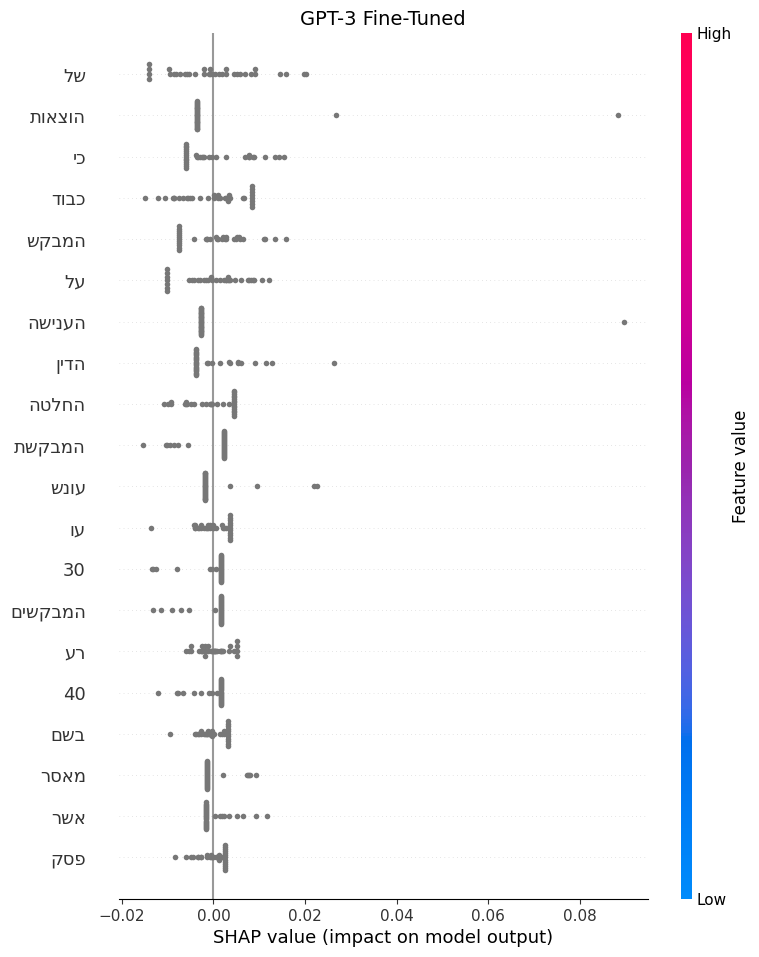

מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. של - השפעה ממוצעת: 0.0073
2. הוצאות - השפעה ממוצעת: 0.0066
3. כי - השפעה ממוצעת: 0.0060
4. כבוד - השפעה ממוצעת: 0.0059
5. המבקש - השפעה ממוצעת: 0.0056


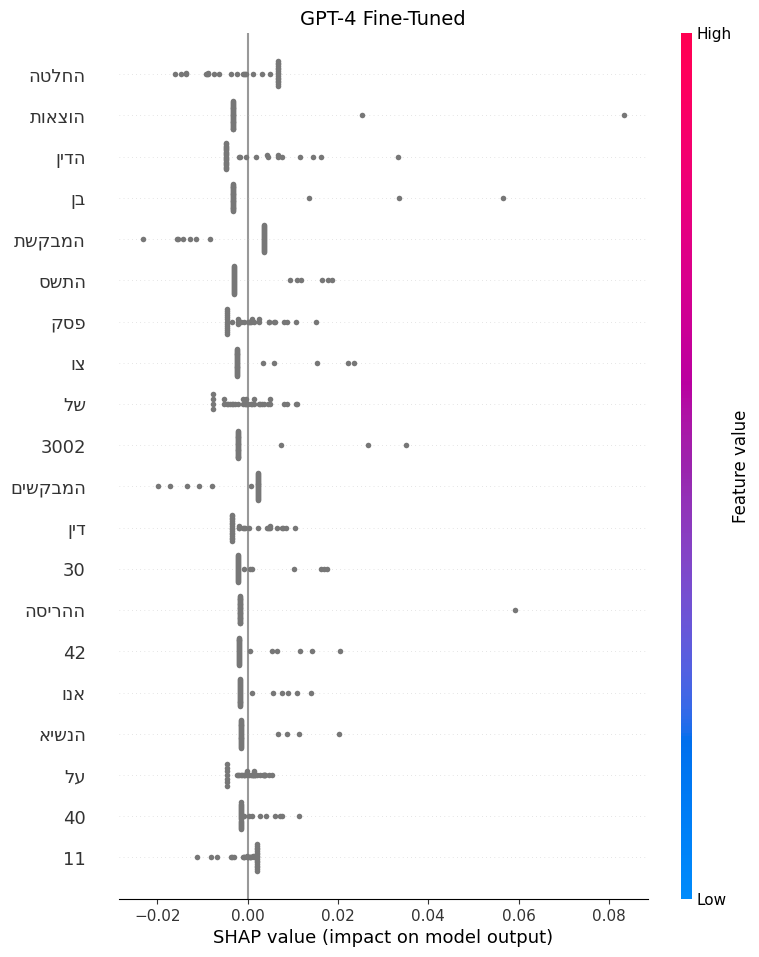

מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. החלטה - השפעה ממוצעת: 0.0066
2. הוצאות - השפעה ממוצעת: 0.0062
3. הדין - השפעה ממוצעת: 0.0061
4. בן - השפעה ממוצעת: 0.0059
5. המבקשת - השפעה ממוצעת: 0.0058


In [ ]:
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת משתני הקלט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי (מה שהמודלים חזו)
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות SHAP
shap_results = {}

# מעבר על שני המודלים וביצוע SHAP לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של SHAP
    explainer = shap.Explainer(clf, X_tfidf)
    shap_values = explainer(X_tfidf)

    # שמירת התוצאות במילון
    shap_results[model_name] = shap_values

    # יצירת גרף SHAP מסכם
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, feature_names=[w[::-1] for w in vectorizer.get_feature_names_out()], show=False)

    # כותרת בעברית מודפסת בהיפוך לצורך הצגת טקסט נכון
    plt.title(f"{model_name}", fontsize=14)
    plt.show()

    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print("חמשת הפיצ'רים המשפיעים ביותר:")

    # הצגת חמשת הפיצ'רים המשפיעים ביותר
    top_features = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:][::-1]
    for i, feature_idx in enumerate(top_features, 1):
        feature_name = vectorizer.get_feature_names_out()[feature_idx]  # לא הופכים עברית בהדפסה הרגילה
        avg_impact = np.abs(shap_values.values[:, feature_idx]).mean()
        print(f"{i}. {feature_name} - השפעה ממוצעת: {avg_impact:.4f}")

    print("=" * 60)


In [ ]:
import lime
import lime.lime_text
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת נתוני הטקסט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות LIME
lime_results = {}

# מעבר על שני המודלים וביצוע LIME לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של LIME
    explainer = lime.lime_text.LimeTextExplainer(class_names=["Rejected", "Accepted"])

    # בחירת פסק דין אקראי לבדיקה
    idx = np.random.randint(0, len(X_text))
    text_sample = X_text.iloc[idx]

    # פונקציה לחיזוי הסתברויות על טקסטים
    def predict_proba(texts):
        tfidf_texts = vectorizer.transform(texts)
        return clf.predict_proba(tfidf_texts)

    # יצירת ההסבר של LIME
    exp = explainer.explain_instance(
        text_sample,
        predict_proba,
        num_features=10  # הצגת 10 המילים הכי משפיעות
    )

    # שמירת התוצאה
    lime_results[model_name] = exp

    # הצגת ההסבר
    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print(f"פסק דין נבחר (ID: {idx}):\n{text_sample[:500]} ...")  # הצגת 500 תווים ראשונים בלבד

    # הצגת 3 הפיצ'רים המשפיעים ביותר
    top_features = exp.as_list()[:3]
    print("\n📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:")
    for i, (word, impact) in enumerate(top_features, 1):
        print(f"{i}. '{word}' - השפעה: {impact:.4f}")

    print("=" * 60)

    # הצגת גרף LIME
    exp.show_in_notebook()


מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 10):
['החלטה בתיק רע"פ 7771/11 בבית המשפט העליון רע"פ 7771/11 - א\' בפני: כבוד השופטת מ\' נאור המבקש: יוסף מראר נגד המשיבה: מדינת ישראל בקשה לעיכוב ביצוע בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד שאול כהן החלטה המדינה הודיעה כי היא אינה מתנגדת לבקשה ועל כן אני נעתרת לה ומורה על עיכוב ביצוע רכיב המאסר במובן זה שהמבקש יתייצב לריצוי מאסרו בבית המשפט לתעבורה מרכז ביום 10.11.2011 עד השעה 12:00 (במקום ביום 30.10.2011). בכך הסתיים הטיפול בתיק. ניתנה היום, ל\' בתשרי התשע"ב (28.10.2011). ש ו פ ט ת ___________ ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. 'החלטה' - השפעה: -0.0008
2. 'רע' - השפעה: -0.0007
3. 'עו' - השפעה: -0.0007


מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 11):
['החלטה בתיק רע"פ 271/16 בבית המשפט העליון רע"פ 271/16 - א\' לפני: כבוד השופט א\' שהם המבקשת: ילנה שפיר נגד המשיבה: מדינת ישראל בקשה לעיון חוזר בשם המבקשת: עו"ד עופר חורש החלטה כפי שקבעתי בהחלטתי, מיום 17.1.2016, משלא העלתה המבקשת, עם ראשיתו של ההליך, כל השגה הנוגעת לתקינות בדיקת הינשוף שנערכה לה, לא היתה כל סיבה לזמן את עורכי התע"צ לעדות, כמו גם לרשום אותם כעדיה של המשיבה בכתב האישום. הבקשה נדחית. ניתנה היום, \u200fא\' באדר א התשע"ו (\u200f10.2.2016). ש ו פ ט _________________________  ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. 'המבקשת' - השפעה: -0.0022
2. 'החלטה' - השפעה: -0.0015
3. 'כל' - השפעה: 0.0007
